In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 

meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_89167/2826483081.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


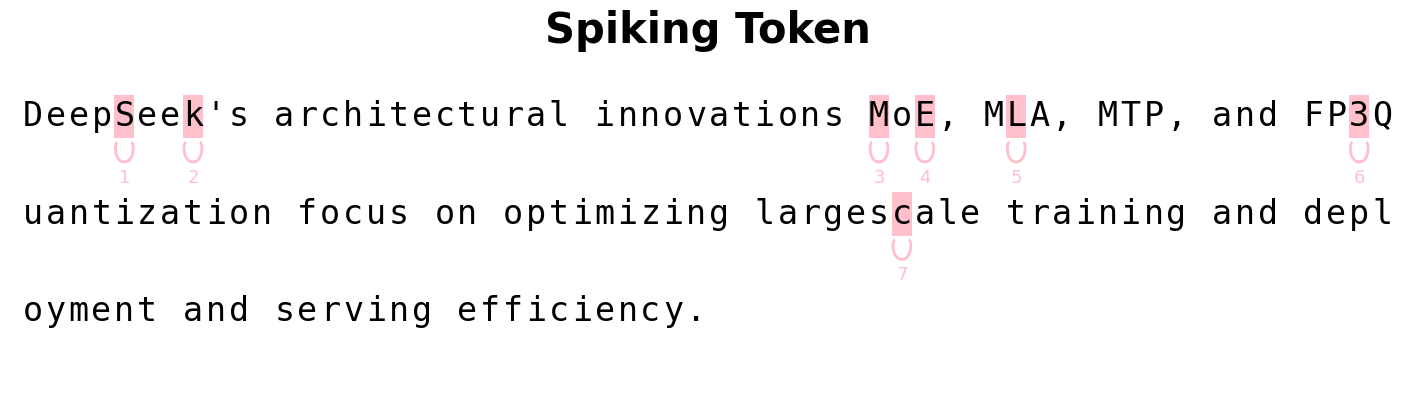

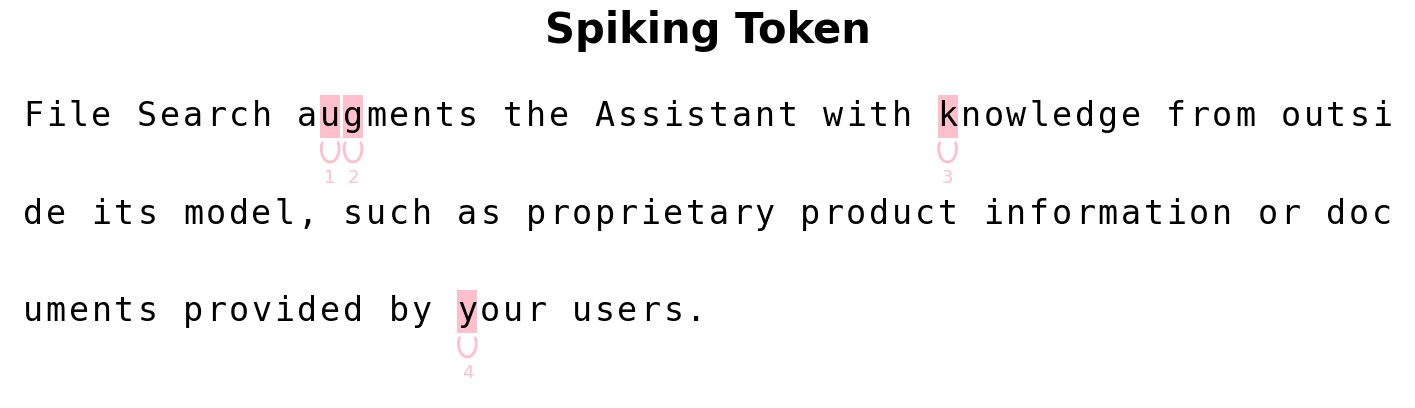

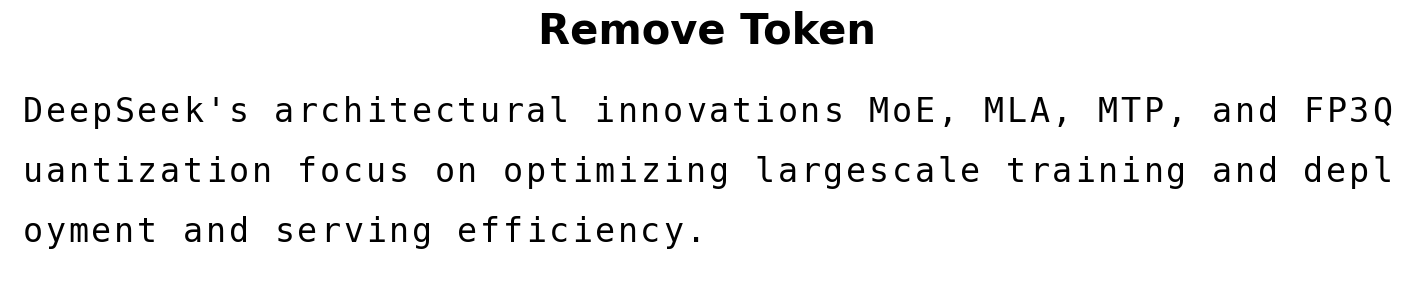

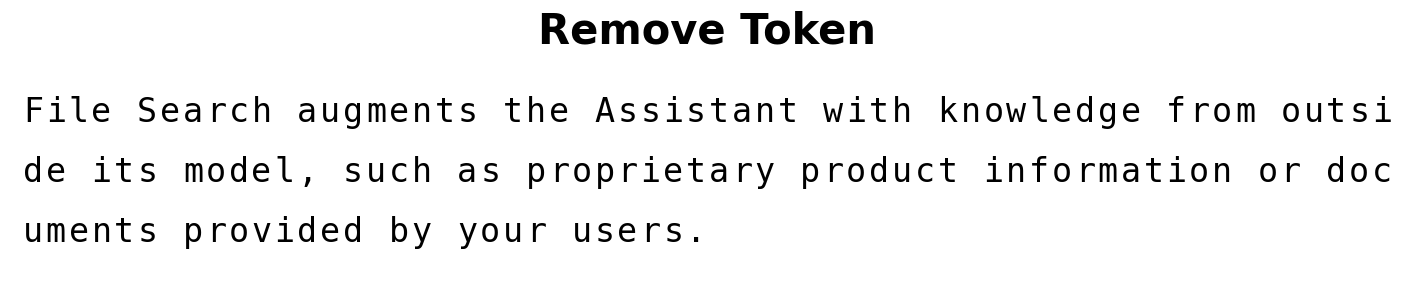

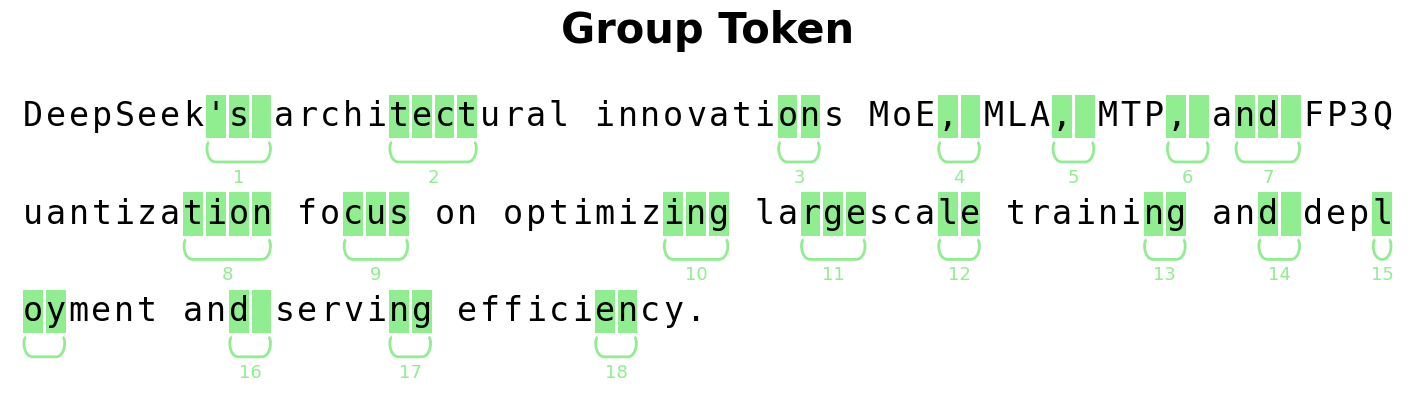

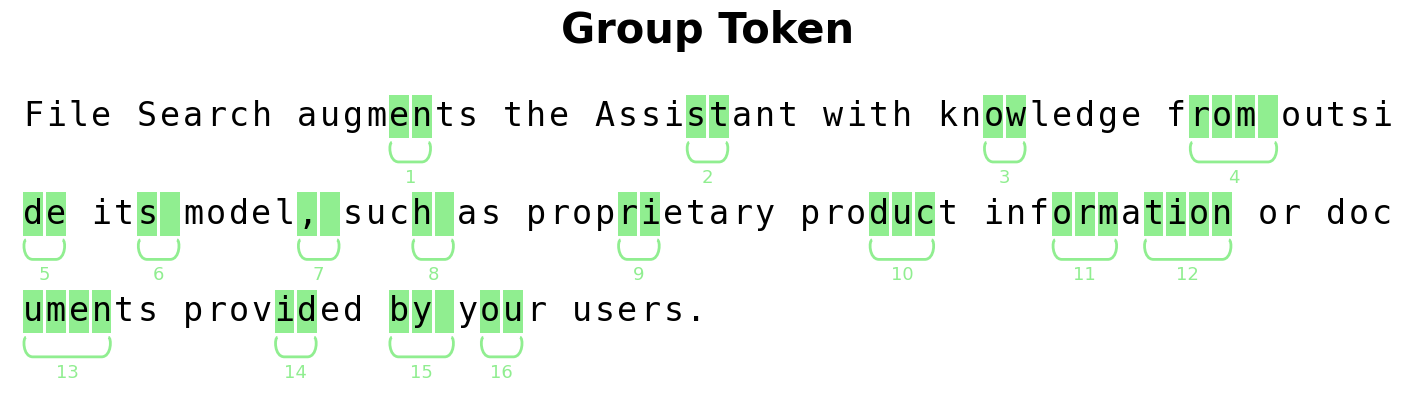

In [2]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=0.2)

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [3]:
# cache vocabulary change 
magicab.cache_vocab_change(texts)

# update vocabulary :: Need to speed-up 'add_token' for ETokenizer 
magicab.update_vocab(max_size_change=100)

Begin vocabulary change caching ...
 - Inference took: 0.0403 seconds
 - Remove token detection took: 0.0003 seconds
 - Group token detection took: 0.0015 seconds
Function _prep_vocabulary_addition took 0.0006 seconds
 - Vocabulary addition (inference required) prep took: 0.0006 seconds
 - Token removal prep took: 0.0001 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.0443 seconds
:: Total 39 token groups, added 54 pairwise merges
:: Total 54 new tokens added
Function add_to_vocab took 0.0011 seconds
:: Total 0 tokens to remove
Function remove_from_vocab took 0.0009 seconds


In [ ]:

from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
t0 = time.time()
prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
t1 = time.time()
print("Time taken to update data: ", t1 - t0)

data_dir = "data/enwiki/"
block_size = 256
batch_size = 4
device_type = "cpu"

# Update vocabulary on training data
# vocabulary grows huge very soon, need to cap on allowed size change
update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change=200) 
t2 = time.time() 
print("Time taken to update vocabulary: ", t2 - t1)

Input file path:  data/enwiki/enwik8_clean.txt
Encoding data with tokenizer ...
Total tokens: 54482072
Vocab size: 146
train has 42,207,117 tokens
val has 1,681,387 tokens
test has 2,092,895 tokens
Time taken to update data:  28.36811065673828


Updating Magicab Vocabulary:   0%|          | 0/41218 [00:00<?, ?it/s]

Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 1/41218 [00:00<1:43:41,  6.62it/s]

 - Inference took: 0.1351 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0006 seconds
 - Vocabulary addition (inference required) prep took: 0.0006 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1495 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 2/41218 [00:00<1:33:47,  7.32it/s]

 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1256 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 3/41218 [00:00<1:28:04,  7.80it/s]

 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0005 seconds
 - Vocabulary addition (inference required) prep took: 0.0005 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1175 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 4/41218 [00:00<1:30:27,  7.59it/s]

 - Inference took: 0.1220 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0006 seconds
 - Vocabulary addition (inference required) prep took: 0.0006 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1364 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 5/41218 [00:00<1:30:15,  7.61it/s]

 - Inference took: 0.1128 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0006 seconds
 - Vocabulary addition (inference required) prep took: 0.0006 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1303 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 6/41218 [00:00<1:29:30,  7.67it/s]

 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1275 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 7/41218 [00:00<1:31:56,  7.47it/s]

 - Inference took: 0.1228 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1405 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 8/41218 [00:01<1:36:32,  7.11it/s]

 - Inference took: 0.1335 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1542 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 9/41218 [00:01<1:35:08,  7.22it/s]

 - Inference took: 0.1148 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1335 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 10/41218 [00:01<1:39:41,  6.89it/s]

 - Inference took: 0.1412 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0041 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1589 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 11/41218 [00:01<1:42:10,  6.72it/s]

 - Inference took: 0.1355 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1563 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 12/41218 [00:01<1:47:09,  6.41it/s]

 - Inference took: 0.1365 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1719 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1438 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0041 seconds
Function _prep_vocabulary_addition took 0.0006 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0002 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   0%|          | 13/41218 [00:01<1:49:14,  6.29it/s]

Function _cache_vocabulary_change took 0.1651 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1731 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0071 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0011 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   0%|          | 14/41218 [00:02<2:02:40,  5.60it/s]

Function _cache_vocabulary_change took 0.2223 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1460 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   0%|          | 15/41218 [00:02<2:01:24,  5.66it/s]

Function _cache_vocabulary_change took 0.1712 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 17/41218 [00:02<2:11:01,  5.24it/s]

 - Inference took: 0.2391 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2587 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1501 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1650 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 19/41218 [00:02<1:46:31,  6.45it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1201 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1205 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 21/41218 [00:03<1:35:22,  7.20it/s]

 - Inference took: 0.1130 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0007 seconds
 - Vocabulary addition (inference required) prep took: 0.0007 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1179 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 23/41218 [00:03<1:27:25,  7.85it/s]

 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1148 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1160 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 25/41218 [00:03<1:23:56,  8.18it/s]

 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0041 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1184 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1154 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 27/41218 [00:03<1:23:12,  8.25it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1211 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1186 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 29/41218 [00:04<1:25:47,  8.00it/s]

 - Inference took: 0.1149 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0008 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1332 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0041 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1242 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 31/41218 [00:04<1:23:57,  8.18it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0008 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1205 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0003 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1182 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 33/41218 [00:04<1:23:36,  8.21it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0010 seconds
 - Vocabulary addition (inference required) prep took: 0.0010 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1207 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1207 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 35/41218 [00:04<1:22:50,  8.29it/s]

 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0010 seconds
 - Vocabulary addition (inference required) prep took: 0.0010 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1207 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0009 seconds
 - Vocabulary addition (inference required) prep took: 0.0009 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1179 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 37/41218 [00:05<1:21:41,  8.40it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0010 seconds
 - Vocabulary addition (inference required) prep took: 0.0010 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1166 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0010 seconds
 - Vocabulary addition (inference required) prep took: 0.0010 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1170 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 39/41218 [00:05<1:21:46,  8.39it/s]

 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0010 seconds
 - Vocabulary addition (inference required) prep took: 0.0010 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1170 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0004 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1198 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 41/41218 [00:05<1:22:31,  8.32it/s]

 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1241 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0011 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1185 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 43/41218 [00:05<1:23:01,  8.27it/s]

 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0041 seconds
Function _prep_vocabulary_addition took 0.0010 seconds
 - Vocabulary addition (inference required) prep took: 0.0010 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1203 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1216 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 45/41218 [00:06<1:28:25,  7.76it/s]

 - Inference took: 0.1213 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1474 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0011 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1277 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 47/41218 [00:06<1:29:35,  7.66it/s]

 - Inference took: 0.0999 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1234 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0011 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1373 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 49/41218 [00:06<1:31:54,  7.47it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0011 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1345 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1126 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0011 seconds
 - Vocabulary addition (inference required) prep took: 0.0011 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1379 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 50/41218 [00:06<1:31:12,  7.52it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1298 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 52/41218 [00:07<1:45:32,  6.50it/s]

 - Inference took: 0.2232 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2428 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0005 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1246 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 54/41218 [00:07<1:49:38,  6.26it/s]

 - Inference took: 0.1289 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1563 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1317 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 56/41218 [00:07<1:47:06,  6.40it/s]

 - Inference took: 0.1306 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1604 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1453 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 58/41218 [00:08<1:44:17,  6.58it/s]

 - Inference took: 0.1593 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1773 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1259 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 60/41218 [00:08<1:35:10,  7.21it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1238 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1264 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 62/41218 [00:08<1:28:55,  7.71it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1196 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1208 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 64/41218 [00:08<1:25:34,  8.02it/s]

 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1185 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1194 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 66/41218 [00:09<1:22:23,  8.32it/s]

 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1185 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0978 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0012 seconds
 - Vocabulary addition (inference required) prep took: 0.0012 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1127 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 68/41218 [00:09<1:23:53,  8.17it/s]

 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1219 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1252 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 70/41218 [00:09<1:24:25,  8.12it/s]

 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0006 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1202 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1253 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 72/41218 [00:09<1:29:33,  7.66it/s]

 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0013 seconds
 - Vocabulary addition (inference required) prep took: 0.0013 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1285 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1254 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1433 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 74/41218 [00:10<1:33:23,  7.34it/s]

 - Inference took: 0.1511 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0007 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1200 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 76/41218 [00:10<1:28:58,  7.71it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1188 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1260 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 78/41218 [00:10<1:36:01,  7.14it/s]

 - Inference took: 0.1206 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1414 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1217 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1547 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 80/41218 [00:10<1:35:17,  7.19it/s]

 - Inference took: 0.1166 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1418 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0014 seconds
 - Vocabulary addition (inference required) prep took: 0.0014 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1333 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 82/41218 [00:11<1:31:28,  7.49it/s]

 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1269 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1278 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 84/41218 [00:11<1:28:45,  7.72it/s]

 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1201 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1286 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 86/41218 [00:11<1:44:05,  6.59it/s]

 - Inference took: 0.2011 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0008 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2224 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1159 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1380 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 88/41218 [00:12<1:35:57,  7.14it/s]

 - Inference took: 0.1131 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1307 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1250 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 90/41218 [00:12<1:28:51,  7.71it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1271 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0982 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1131 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 92/41218 [00:12<1:28:15,  7.77it/s]

 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0015 seconds
 - Vocabulary addition (inference required) prep took: 0.0015 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1277 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1271 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 94/41218 [00:12<1:26:38,  7.91it/s]

 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0024 seconds
 - Vocabulary addition (inference required) prep took: 0.0024 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1258 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1220 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 96/41218 [00:13<1:26:33,  7.92it/s]

 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1257 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1255 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 98/41218 [00:13<1:23:58,  8.16it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1188 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1003 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1180 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 100/41218 [00:13<1:24:56,  8.07it/s]

 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1219 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1266 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 102/41218 [00:13<1:25:47,  7.99it/s]

 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0029 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1264 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1253 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 104/41218 [00:14<1:24:55,  8.07it/s]

 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1200 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1229 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 106/41218 [00:14<1:25:18,  8.03it/s]

 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1181 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1288 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 108/41218 [00:14<1:25:46,  7.99it/s]

 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1238 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0009 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1261 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 110/41218 [00:14<1:25:57,  7.97it/s]

 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1268 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1238 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 112/41218 [00:15<1:26:03,  7.96it/s]

 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1184 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1114 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1299 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 114/41218 [00:15<1:25:29,  8.01it/s]

 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0017 seconds
 - Vocabulary addition (inference required) prep took: 0.0017 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1281 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1012 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1202 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 116/41218 [00:15<1:41:07,  6.77it/s]

 - Inference took: 0.2134 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2349 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1227 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 118/41218 [00:15<1:33:28,  7.33it/s]

 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1272 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1017 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0016 seconds
 - Vocabulary addition (inference required) prep took: 0.0016 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1236 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 120/41218 [00:16<1:31:44,  7.47it/s]

 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0010 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1282 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1319 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 122/41218 [00:16<1:27:14,  7.85it/s]

 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1206 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1203 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 124/41218 [00:16<1:26:14,  7.94it/s]

 - Inference took: 0.0995 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0029 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1191 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1272 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 126/41218 [00:16<1:27:50,  7.80it/s]

 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1282 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1312 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 128/41218 [00:17<1:24:51,  8.07it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1217 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0993 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1173 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 130/41218 [00:17<1:24:46,  8.08it/s]

 - Inference took: 0.1012 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1204 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1249 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 132/41218 [00:17<1:23:24,  8.21it/s]

 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1228 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0976 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1167 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 134/41218 [00:17<1:24:44,  8.08it/s]

 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1280 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0011 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1230 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 136/41218 [00:18<1:24:36,  8.09it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1247 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1214 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 138/41218 [00:18<1:24:22,  8.11it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0018 seconds
 - Vocabulary addition (inference required) prep took: 0.0018 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1230 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1218 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 140/41218 [00:18<1:26:00,  7.96it/s]

 - Inference took: 0.1103 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1268 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1278 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 142/41218 [00:18<1:26:08,  7.95it/s]

 - Inference took: 0.1014 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1204 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1085 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1290 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 144/41218 [00:19<1:26:17,  7.93it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1269 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1247 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 146/41218 [00:19<1:25:23,  8.02it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1250 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0999 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0019 seconds
 - Vocabulary addition (inference required) prep took: 0.0019 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1214 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 148/41218 [00:19<1:26:04,  7.95it/s]

 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0024 seconds
 - Vocabulary addition (inference required) prep took: 0.0024 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1280 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0012 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1247 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 150/41218 [00:20<1:43:17,  6.63it/s]

 - Inference took: 0.2057 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2326 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1338 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 152/41218 [00:20<1:35:10,  7.19it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1248 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1287 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 154/41218 [00:20<1:32:11,  7.42it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1301 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 156/41218 [00:20<1:32:29,  7.40it/s]

 - Inference took: 0.1182 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0013 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1432 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0020 seconds
 - Vocabulary addition (inference required) prep took: 0.0020 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1292 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 158/41218 [00:21<1:31:29,  7.48it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1288 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1338 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 160/41218 [00:21<1:31:32,  7.47it/s]

 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1365 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1309 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 162/41218 [00:21<1:28:33,  7.73it/s]

 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0029 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1279 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1017 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0017 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1223 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 164/41218 [00:21<1:30:47,  7.54it/s]

 - Inference took: 0.1117 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1408 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1313 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 166/41218 [00:22<1:28:31,  7.73it/s]

 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1314 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0024 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1215 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 168/41218 [00:22<1:28:56,  7.69it/s]

 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0014 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1306 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0042 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 170/41218 [00:22<1:28:11,  7.76it/s]

 - Inference took: 0.0988 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1258 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0021 seconds
 - Vocabulary addition (inference required) prep took: 0.0021 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1281 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 172/41218 [00:22<1:30:40,  7.54it/s]

 - Inference took: 0.1128 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1366 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1346 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 174/41218 [00:23<1:30:30,  7.56it/s]

 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1298 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1004 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0016 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1326 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 176/41218 [00:23<1:29:32,  7.64it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0016 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1262 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1307 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 178/41218 [00:23<1:29:57,  7.60it/s]

 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1344 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1293 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 180/41218 [00:23<1:30:44,  7.54it/s]

 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1328 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0022 seconds
 - Vocabulary addition (inference required) prep took: 0.0022 seconds
 - Token removal prep took: 0.0015 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1334 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 182/41218 [00:24<1:28:20,  7.74it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0023 seconds
 - Vocabulary addition (inference required) prep took: 0.0023 seconds
 - Token removal prep took: 0.0016 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1284 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0996 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0025 seconds
 - Vocabulary addition (inference required) prep took: 0.0025 seconds
 - Token removal prep took: 0.0017 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1229 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 184/41218 [00:24<1:43:52,  6.58it/s]

 - Inference took: 0.2134 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0018 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2365 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0018 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1284 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 186/41218 [00:24<1:37:55,  6.98it/s]

 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0024 seconds
 - Vocabulary addition (inference required) prep took: 0.0024 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1336 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0031 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1346 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 188/41218 [00:25<1:35:21,  7.17it/s]

 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1355 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1350 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 190/41218 [00:25<1:32:07,  7.42it/s]

 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1338 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0988 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0043 seconds
 - Vocabulary addition (inference required) prep took: 0.0043 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1265 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 192/41218 [00:25<1:31:19,  7.49it/s]

 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1317 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1317 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 194/41218 [00:25<1:31:10,  7.50it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0025 seconds
 - Vocabulary addition (inference required) prep took: 0.0025 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1343 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0019 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1313 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 196/41218 [00:26<1:30:25,  7.56it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1309 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1303 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 198/41218 [00:26<1:28:51,  7.69it/s]

 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1313 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1243 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 200/41218 [00:26<1:29:21,  7.65it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1294 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 202/41218 [00:26<1:29:53,  7.60it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1287 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1334 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 204/41218 [00:27<1:31:02,  7.51it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1317 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1359 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   0%|          | 206/41218 [00:27<1:31:08,  7.50it/s]

 - Inference took: 0.1082 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1376 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 208/41218 [00:27<1:31:26,  7.47it/s]

 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0025 seconds
 - Vocabulary addition (inference required) prep took: 0.0025 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1333 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1338 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 210/41218 [00:28<1:31:00,  7.51it/s]

 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1338 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1307 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 212/41218 [00:28<1:32:47,  7.37it/s]

 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1333 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1408 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 214/41218 [00:28<1:31:12,  7.49it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1298 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1313 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 216/41218 [00:28<1:30:12,  7.58it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1296 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1299 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 218/41218 [00:29<1:44:40,  6.53it/s]

 - Inference took: 0.2048 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2305 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0020 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 220/41218 [00:29<1:34:53,  7.20it/s]

 - Inference took: 0.0982 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1221 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0994 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0026 seconds
 - Vocabulary addition (inference required) prep took: 0.0026 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1261 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 222/41218 [00:29<1:32:07,  7.42it/s]

 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1335 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1280 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 224/41218 [00:29<1:32:01,  7.42it/s]

 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1309 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1360 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 226/41218 [00:30<1:32:21,  7.40it/s]

 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0022 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1384 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 228/41218 [00:30<1:31:32,  7.46it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1344 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1307 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 230/41218 [00:30<1:33:06,  7.34it/s]

 - Inference took: 0.1137 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1095 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1335 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 232/41218 [00:31<1:36:36,  7.07it/s]

 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0027 seconds
 - Vocabulary addition (inference required) prep took: 0.0027 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1271 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1329 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0027 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1586 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 234/41218 [00:31<1:35:46,  7.13it/s]

 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0022 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1437 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0021 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1348 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 236/41218 [00:31<1:33:05,  7.34it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1348 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1298 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 238/41218 [00:31<1:40:01,  6.83it/s]

 - Inference took: 0.1471 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1759 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0022 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1412 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 240/41218 [00:32<1:36:38,  7.07it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0029 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1318 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1143 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0028 seconds
 - Vocabulary addition (inference required) prep took: 0.0028 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1389 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 242/41218 [00:32<1:39:12,  6.88it/s]

 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0029 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0024 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1357 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1314 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1569 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 244/41218 [00:32<1:34:47,  7.20it/s]

 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1358 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1293 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 246/41218 [00:33<1:32:38,  7.37it/s]

 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0011 seconds
 - Group token detection took: 0.0088 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1322 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0023 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1318 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 248/41218 [00:33<1:31:48,  7.44it/s]

 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0031 seconds
 - Token removal prep took: 0.0024 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0995 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0031 seconds
 - Token removal prep took: 0.0024 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1321 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 249/41218 [00:33<1:31:56,  7.43it/s]

 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0024 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1344 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 251/41218 [00:33<1:47:30,  6.35it/s]

 - Inference took: 0.2178 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0029 seconds
 - Vocabulary addition (inference required) prep took: 0.0029 seconds
 - Token removal prep took: 0.0025 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2455 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0024 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1322 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 253/41218 [00:34<1:38:02,  6.96it/s]

 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0024 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1353 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0025 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1255 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 255/41218 [00:34<1:35:44,  7.13it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0025 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1252 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1178 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0031 seconds
 - Token removal prep took: 0.0030 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 257/41218 [00:34<1:33:51,  7.27it/s]

 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0026 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1360 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0032 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0029 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1329 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 259/41218 [00:34<1:31:59,  7.42it/s]

 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0027 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1342 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0030 seconds
 - Vocabulary addition (inference required) prep took: 0.0030 seconds
 - Token removal prep took: 0.0026 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 261/41218 [00:35<1:30:28,  7.54it/s]

 - Inference took: 0.1048 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0027 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1286 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0031 seconds
 - Token removal prep took: 0.0026 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1306 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 263/41218 [00:35<1:31:35,  7.45it/s]

 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1379 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0032 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0027 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1332 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 265/41218 [00:35<1:30:30,  7.54it/s]

 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0031 seconds
 - Vocabulary addition (inference required) prep took: 0.0031 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1382 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0032 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0027 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1244 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 267/41218 [00:35<1:30:08,  7.57it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1269 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0027 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1339 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 269/41218 [00:36<1:29:53,  7.59it/s]

 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0032 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1373 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1260 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 271/41218 [00:36<1:29:44,  7.60it/s]

 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1269 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1333 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 273/41218 [00:36<1:29:54,  7.59it/s]

 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0028 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1293 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0029 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1329 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 275/41218 [00:37<1:35:32,  7.14it/s]

 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1427 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1212 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0030 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1497 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 277/41218 [00:37<1:35:31,  7.14it/s]

 - Inference took: 0.1122 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1384 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1158 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 279/41218 [00:37<1:32:41,  7.36it/s]

 - Inference took: 0.1142 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0032 seconds
 - Vocabulary addition (inference required) prep took: 0.0032 seconds
 - Token removal prep took: 0.0030 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0029 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1259 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 281/41218 [00:37<1:33:56,  7.26it/s]

 - Inference took: 0.1136 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0029 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1472 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0029 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 283/41218 [00:38<1:45:04,  6.49it/s]

 - Inference took: 0.1991 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0033 seconds
 - Vocabulary addition (inference required) prep took: 0.0033 seconds
 - Token removal prep took: 0.0030 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2272 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0030 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1283 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 285/41218 [00:38<1:39:57,  6.83it/s]

 - Inference took: 0.1081 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0030 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1341 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1129 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1419 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 287/41218 [00:38<1:38:19,  6.94it/s]

 - Inference took: 0.1193 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1467 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1373 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 289/41218 [00:39<1:35:12,  7.17it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1288 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1385 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 291/41218 [00:39<1:35:19,  7.16it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1406 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1101 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1381 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 293/41218 [00:39<1:32:44,  7.35it/s]

 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1322 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0031 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1314 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 295/41218 [00:39<1:32:10,  7.40it/s]

 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1311 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1354 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 297/41218 [00:40<1:31:10,  7.48it/s]

 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0043 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1346 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1296 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 299/41218 [00:40<1:33:06,  7.32it/s]

 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1417 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1365 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 301/41218 [00:40<1:35:41,  7.13it/s]

 - Inference took: 0.1135 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1135 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1426 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 303/41218 [00:40<1:34:50,  7.19it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1401 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1351 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 305/41218 [00:41<1:34:54,  7.19it/s]

 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1331 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1423 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 307/41218 [00:41<1:34:45,  7.20it/s]

 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1421 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1076 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1354 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 309/41218 [00:41<1:33:59,  7.25it/s]

 - Inference took: 0.1103 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1368 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0034 seconds
 - Vocabulary addition (inference required) prep took: 0.0034 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1357 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 311/41218 [00:42<1:32:47,  7.35it/s]

 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1346 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1332 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 313/41218 [00:42<1:33:56,  7.26it/s]

 - Inference took: 0.1126 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0035 seconds
 - Vocabulary addition (inference required) prep took: 0.0035 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1396 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0032 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1381 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 315/41218 [00:42<1:48:49,  6.26it/s]

 - Inference took: 0.2159 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2477 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1326 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 317/41218 [00:43<1:40:13,  6.80it/s]

 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0033 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1371 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0036 seconds
 - Vocabulary addition (inference required) prep took: 0.0036 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1322 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 319/41218 [00:43<1:36:03,  7.10it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1356 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1336 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 321/41218 [00:43<1:33:53,  7.26it/s]

 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1337 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1344 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 323/41218 [00:43<1:35:12,  7.16it/s]

 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1480 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1356 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 325/41218 [00:44<1:31:58,  7.41it/s]

 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1298 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 327/41218 [00:44<1:32:35,  7.36it/s]

 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1362 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1360 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 329/41218 [00:44<1:35:35,  7.13it/s]

 - Inference took: 0.1137 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1464 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1103 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1422 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 331/41218 [00:44<1:33:40,  7.28it/s]

 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0037 seconds
 - Vocabulary addition (inference required) prep took: 0.0037 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1390 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0034 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1306 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 333/41218 [00:45<1:32:12,  7.39it/s]

 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1343 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1315 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 335/41218 [00:45<1:33:39,  7.28it/s]

 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0036 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1380 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 337/41218 [00:45<1:31:06,  7.48it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0035 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1278 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0036 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1307 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 339/41218 [00:45<1:29:14,  7.63it/s]

 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0036 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1255 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0036 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1292 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 341/41218 [00:46<1:28:51,  7.67it/s]

 - Inference took: 0.1114 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0036 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1354 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0038 seconds
 - Vocabulary addition (inference required) prep took: 0.0038 seconds
 - Token removal prep took: 0.0036 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1251 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 343/41218 [00:46<1:28:04,  7.73it/s]

 - Inference took: 0.1048 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1281 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1270 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 344/41218 [00:46<1:29:17,  7.63it/s]

 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0040 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1338 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 346/41218 [00:47<1:52:41,  6.05it/s]

 - Inference took: 0.2255 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2565 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1226 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1564 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 348/41218 [00:47<1:46:12,  6.41it/s]

 - Inference took: 0.1207 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1520 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1093 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1419 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 350/41218 [00:47<1:40:57,  6.75it/s]

 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0038 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1460 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0038 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1360 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 352/41218 [00:47<1:40:41,  6.76it/s]

 - Inference took: 0.1184 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1465 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1471 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 354/41218 [00:48<1:39:26,  6.85it/s]

 - Inference took: 0.1128 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0039 seconds
 - Vocabulary addition (inference required) prep took: 0.0039 seconds
 - Token removal prep took: 0.0037 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1434 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1130 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0038 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1439 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 356/41218 [00:48<1:38:09,  6.94it/s]

 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0038 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1378 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1122 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0039 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1443 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 358/41218 [00:48<1:41:52,  6.68it/s]

 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1500 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1190 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0040 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1569 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 360/41218 [00:49<1:41:24,  6.71it/s]

 - Inference took: 0.1257 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0040 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0039 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1357 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 362/41218 [00:49<1:38:02,  6.94it/s]

 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0040 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1372 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1396 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 364/41218 [00:49<1:43:04,  6.61it/s]

 - Inference took: 0.1290 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0040 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1661 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1166 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1521 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 365/41218 [00:49<1:43:56,  6.55it/s]

 - Inference took: 0.1151 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0043 seconds
 - Vocabulary addition (inference required) prep took: 0.0043 seconds
 - Token removal prep took: 0.0039 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1548 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1229 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0040 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   1%|          | 367/41218 [00:50<1:46:16,  6.41it/s]

Function _cache_vocabulary_change took 0.1638 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1203 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1552 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 369/41218 [00:50<1:43:18,  6.59it/s]

 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0043 seconds
 - Vocabulary addition (inference required) prep took: 0.0043 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1394 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1158 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0043 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1521 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 371/41218 [00:50<1:44:56,  6.49it/s]

 - Inference took: 0.1174 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0041 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1534 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1210 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0042 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1573 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 373/41218 [00:51<1:40:59,  6.74it/s]

 - Inference took: 0.1127 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0042 seconds
 - Vocabulary addition (inference required) prep took: 0.0042 seconds
 - Token removal prep took: 0.0044 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1459 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0042 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1393 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 374/41218 [00:51<1:43:03,  6.61it/s]

 - Inference took: 0.1175 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0041 seconds
 - Vocabulary addition (inference required) prep took: 0.0041 seconds
 - Token removal prep took: 0.0042 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1577 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 376/41218 [00:51<2:07:23,  5.34it/s]

 - Inference took: 0.2837 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0044 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3261 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0044 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1471 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 378/41218 [00:52<1:54:49,  5.93it/s]

 - Inference took: 0.1121 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0044 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1484 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1180 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0043 seconds
 - Vocabulary addition (inference required) prep took: 0.0043 seconds
 - Token removal prep took: 0.0044 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1515 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 380/41218 [00:52<1:47:47,  6.31it/s]

 - Inference took: 0.1194 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0042 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1527 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0042 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1443 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 382/41218 [00:52<1:43:14,  6.59it/s]

 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0043 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1381 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1164 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0042 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 384/41218 [00:52<1:40:46,  6.75it/s]

 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0044 seconds
 - Token removal prep took: 0.0044 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1386 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0043 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1477 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 386/41218 [00:53<1:39:11,  6.86it/s]

 - Inference took: 0.1127 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1488 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0044 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0043 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 388/41218 [00:53<1:40:32,  6.77it/s]

 - Inference took: 0.1168 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1539 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1456 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 390/41218 [00:53<1:37:40,  6.97it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1351 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1416 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 392/41218 [00:54<1:39:06,  6.87it/s]

 - Inference took: 0.1134 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1504 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 394/41218 [00:54<1:40:31,  6.77it/s]

 - Inference took: 0.1206 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1558 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1140 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 396/41218 [00:54<1:38:03,  6.94it/s]

 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1331 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1449 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 398/41218 [00:54<1:37:18,  6.99it/s]

 - Inference took: 0.1076 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1393 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1101 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1426 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 400/41218 [00:55<1:37:02,  7.01it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1405 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1424 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 402/41218 [00:55<1:40:39,  6.76it/s]

 - Inference took: 0.1093 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0045 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1461 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1568 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 404/41218 [00:55<1:40:16,  6.78it/s]

 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1347 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1541 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 406/41218 [00:56<1:57:19,  5.80it/s]

 - Inference took: 0.2307 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2665 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1464 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 408/41218 [00:56<1:47:53,  6.30it/s]

 - Inference took: 0.1081 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1452 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1437 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 410/41218 [00:56<1:43:35,  6.57it/s]

 - Inference took: 0.1151 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1464 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 412/41218 [00:57<1:41:09,  6.72it/s]

 - Inference took: 0.1114 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1456 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1440 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 414/41218 [00:57<1:41:57,  6.67it/s]

 - Inference took: 0.1113 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1436 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1150 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1547 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 416/41218 [00:57<1:41:07,  6.73it/s]

 - Inference took: 0.1118 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1544 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1416 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 418/41218 [00:57<1:40:43,  6.75it/s]

 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0044 seconds
Function _prep_vocabulary_addition took 0.0045 seconds
 - Vocabulary addition (inference required) prep took: 0.0045 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1524 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1432 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 420/41218 [00:58<1:41:33,  6.70it/s]

 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1494 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1500 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 422/41218 [00:58<1:41:19,  6.71it/s]

 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1431 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1164 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1516 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 424/41218 [00:58<1:42:34,  6.63it/s]

 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1242 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0046 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1571 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 426/41218 [00:59<1:41:42,  6.68it/s]

 - Inference took: 0.1130 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0049 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1502 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1121 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0046 seconds
 - Vocabulary addition (inference required) prep took: 0.0046 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1459 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 428/41218 [00:59<1:40:37,  6.76it/s]

 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0047 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1418 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1130 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0048 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1486 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 430/41218 [00:59<1:40:03,  6.79it/s]

 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0048 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1424 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1482 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 432/41218 [01:00<1:37:58,  6.94it/s]

 - Inference took: 0.1134 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1507 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0051 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1334 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 434/41218 [01:00<1:39:53,  6.80it/s]

 - Inference took: 0.1129 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1477 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1142 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1500 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 436/41218 [01:00<1:54:32,  5.93it/s]

 - Inference took: 0.2105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2424 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1509 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 438/41218 [01:01<1:44:56,  6.48it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0051 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1392 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1409 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 440/41218 [01:01<1:41:20,  6.71it/s]

 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0050 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1472 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0051 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1405 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 442/41218 [01:01<1:40:17,  6.78it/s]

 - Inference took: 0.1113 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0047 seconds
 - Vocabulary addition (inference required) prep took: 0.0047 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1494 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0051 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1426 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 443/41218 [01:01<1:40:01,  6.79it/s]

 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1455 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1207 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   1%|          | 445/41218 [01:02<1:43:31,  6.56it/s]

Function _cache_vocabulary_change took 0.1650 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1501 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 447/41218 [01:02<1:42:02,  6.66it/s]

 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0057 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1363 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1159 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1551 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 449/41218 [01:02<1:37:35,  6.96it/s]

 - Inference took: 0.1076 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1438 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1317 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 451/41218 [01:02<1:40:57,  6.73it/s]

 - Inference took: 0.1252 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1623 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1458 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 453/41218 [01:03<1:40:40,  6.75it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1410 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1164 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1514 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 455/41218 [01:03<1:36:57,  7.01it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0052 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1340 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1387 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 457/41218 [01:03<1:37:58,  6.93it/s]

 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0048 seconds
 - Vocabulary addition (inference required) prep took: 0.0048 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1419 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 459/41218 [01:04<1:37:03,  7.00it/s]

 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1408 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1410 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 461/41218 [01:04<1:35:43,  7.10it/s]

 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1439 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1344 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 463/41218 [01:04<1:37:26,  6.97it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0049 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1378 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1178 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1504 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 465/41218 [01:04<1:37:49,  6.94it/s]

 - Inference took: 0.1135 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0049 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1488 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1404 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 467/41218 [01:05<1:52:34,  6.03it/s]

 - Inference took: 0.2107 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2433 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1458 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 469/41218 [01:05<1:44:50,  6.48it/s]

 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0053 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1460 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1405 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 471/41218 [01:05<1:41:16,  6.71it/s]

 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0056 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1429 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1103 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1436 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 473/41218 [01:06<1:42:02,  6.66it/s]

 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0057 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1460 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1185 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1537 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 475/41218 [01:06<1:42:52,  6.60it/s]

 - Inference took: 0.1189 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1582 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0056 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1475 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 477/41218 [01:06<1:42:28,  6.63it/s]

 - Inference took: 0.1167 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0051 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1518 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1484 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 479/41218 [01:07<1:37:48,  6.94it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0054 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1410 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0051 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1339 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 481/41218 [01:07<1:36:44,  7.02it/s]

 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1424 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0050 seconds
 - Vocabulary addition (inference required) prep took: 0.0050 seconds
 - Token removal prep took: 0.0056 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 483/41218 [01:07<1:35:33,  7.11it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0057 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1394 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0056 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1377 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 485/41218 [01:07<1:35:27,  7.11it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1349 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1433 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 487/41218 [01:08<1:35:15,  7.13it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0057 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1398 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0052 seconds
 - Vocabulary addition (inference required) prep took: 0.0052 seconds
 - Token removal prep took: 0.0055 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1393 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 489/41218 [01:08<1:38:20,  6.90it/s]

 - Inference took: 0.1134 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0056 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1566 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1431 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 491/41218 [01:08<1:35:24,  7.11it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0056 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1379 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0057 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1344 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 493/41218 [01:09<1:35:21,  7.12it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0060 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1412 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0057 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1389 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 495/41218 [01:09<1:32:30,  7.34it/s]

 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0057 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1348 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1295 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 497/41218 [01:09<1:33:05,  7.29it/s]

 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0057 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1372 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0060 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1376 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 499/41218 [01:09<1:35:08,  7.13it/s]

 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0059 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1394 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 501/41218 [01:10<1:33:33,  7.25it/s]

 - Inference took: 0.0986 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0059 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1289 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1391 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 503/41218 [01:10<1:47:19,  6.32it/s]

 - Inference took: 0.2021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0059 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2345 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0058 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1368 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 505/41218 [01:10<1:40:50,  6.73it/s]

 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0057 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1375 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1397 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 507/41218 [01:11<1:37:02,  6.99it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0060 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1392 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1356 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 509/41218 [01:11<1:33:33,  7.25it/s]

 - Inference took: 0.0994 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1372 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0974 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1285 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 511/41218 [01:11<1:34:22,  7.19it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0062 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1369 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1073 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1415 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 513/41218 [01:11<1:34:54,  7.15it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0053 seconds
 - Vocabulary addition (inference required) prep took: 0.0053 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1085 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0062 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1401 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|          | 515/41218 [01:12<1:33:32,  7.25it/s]

 - Inference took: 0.1005 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0057 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1317 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0063 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1380 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 517/41218 [01:12<1:35:01,  7.14it/s]

 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0061 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1392 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0063 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1427 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 519/41218 [01:12<1:34:03,  7.21it/s]

 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0062 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1428 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1010 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0062 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 521/41218 [01:13<1:35:43,  7.09it/s]

 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0062 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0063 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1419 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 523/41218 [01:13<1:33:52,  7.23it/s]

 - Inference took: 0.1005 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0063 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1362 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0054 seconds
 - Vocabulary addition (inference required) prep took: 0.0054 seconds
 - Token removal prep took: 0.0063 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1345 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 525/41218 [01:13<1:34:37,  7.17it/s]

 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0055 seconds
 - Vocabulary addition (inference required) prep took: 0.0055 seconds
 - Token removal prep took: 0.0064 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1416 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0063 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1387 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 527/41218 [01:13<1:33:34,  7.25it/s]

 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0057 seconds
 - Token removal prep took: 0.0062 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1376 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1005 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0068 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1348 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 529/41218 [01:14<1:34:27,  7.18it/s]

 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0069 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1381 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0056 seconds
 - Vocabulary addition (inference required) prep took: 0.0056 seconds
 - Token removal prep took: 0.0069 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1412 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 531/41218 [01:14<1:34:44,  7.16it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0070 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1395 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0069 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1395 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 533/41218 [01:14<1:36:35,  7.02it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0071 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1420 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0069 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 535/41218 [01:15<1:36:04,  7.06it/s]

 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0045 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0071 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0058 seconds
 - Vocabulary addition (inference required) prep took: 0.0058 seconds
 - Token removal prep took: 0.0069 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1374 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 537/41218 [01:15<1:35:01,  7.13it/s]

 - Inference took: 0.1006 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0059 seconds
 - Token removal prep took: 0.0069 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1375 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0070 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1379 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 539/41218 [01:15<1:35:04,  7.13it/s]

 - Inference took: 0.1073 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0063 seconds
 - Vocabulary addition (inference required) prep took: 0.0063 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1402 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1393 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 541/41218 [01:15<1:36:01,  7.06it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1382 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0071 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1453 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 543/41218 [01:16<1:48:06,  6.27it/s]

 - Inference took: 0.1989 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0071 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2373 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0057 seconds
 - Vocabulary addition (inference required) prep took: 0.0057 seconds
 - Token removal prep took: 0.0071 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1330 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 545/41218 [01:16<1:46:16,  6.38it/s]

 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0071 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1461 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1209 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0063 seconds
 - Vocabulary addition (inference required) prep took: 0.0063 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1585 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 547/41218 [01:16<1:41:09,  6.70it/s]

 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1391 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1430 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 549/41218 [01:17<1:37:16,  6.97it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1397 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0059 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1358 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 551/41218 [01:17<1:36:23,  7.03it/s]

 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0080 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1385 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1416 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 553/41218 [01:17<1:35:16,  7.11it/s]

 - Inference took: 0.1081 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1463 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0990 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1328 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 555/41218 [01:17<1:33:49,  7.22it/s]

 - Inference took: 0.0997 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1332 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0074 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1376 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 557/41218 [01:18<1:32:51,  7.30it/s]

 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1351 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1351 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 559/41218 [01:18<1:32:25,  7.33it/s]

 - Inference took: 0.0996 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1309 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0074 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1382 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 561/41218 [01:18<1:32:16,  7.34it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0063 seconds
 - Vocabulary addition (inference required) prep took: 0.0063 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1387 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1001 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0075 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1328 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 563/41218 [01:19<1:32:31,  7.32it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1352 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1371 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 565/41218 [01:19<1:32:33,  7.32it/s]

 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1411 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0074 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1323 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 567/41218 [01:19<1:32:33,  7.32it/s]

 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1363 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0073 seconds
 - Vocabulary addition (inference required) prep took: 0.0073 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1358 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 568/41218 [01:19<1:32:45,  7.30it/s]

 - Inference took: 0.1014 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1370 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 570/41218 [01:20<1:47:15,  6.32it/s]

 - Inference took: 0.2026 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0073 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2364 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1377 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 572/41218 [01:20<1:40:23,  6.75it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0060 seconds
 - Vocabulary addition (inference required) prep took: 0.0060 seconds
 - Token removal prep took: 0.0072 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1381 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0074 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1377 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 574/41218 [01:20<1:38:07,  6.90it/s]

 - Inference took: 0.1001 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1417 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 576/41218 [01:20<1:35:36,  7.08it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1424 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0991 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0063 seconds
 - Vocabulary addition (inference required) prep took: 0.0063 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1330 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 578/41218 [01:21<1:33:38,  7.23it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0076 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1346 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1351 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 580/41218 [01:21<1:34:30,  7.17it/s]

 - Inference took: 0.1012 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0074 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1342 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0061 seconds
 - Vocabulary addition (inference required) prep took: 0.0061 seconds
 - Token removal prep took: 0.0076 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 582/41218 [01:21<1:33:49,  7.22it/s]

 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1366 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1372 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 584/41218 [01:22<1:34:28,  7.17it/s]

 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0076 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1408 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0076 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1391 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 586/41218 [01:22<1:36:18,  7.03it/s]

 - Inference took: 0.1010 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1342 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1122 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0075 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1512 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 588/41218 [01:22<1:37:36,  6.94it/s]

 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0073 seconds
 - Vocabulary addition (inference required) prep took: 0.0073 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1458 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1089 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0063 seconds
 - Vocabulary addition (inference required) prep took: 0.0063 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1451 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 590/41218 [01:22<1:40:18,  6.75it/s]

 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1358 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1191 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1619 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 592/41218 [01:23<1:38:46,  6.85it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1425 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1436 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 594/41218 [01:23<1:39:25,  6.81it/s]

 - Inference took: 0.1202 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1655 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0062 seconds
 - Vocabulary addition (inference required) prep took: 0.0062 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1342 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 596/41218 [01:23<1:42:43,  6.59it/s]

 - Inference took: 0.1136 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0078 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1537 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1143 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0081 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1570 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 598/41218 [01:24<1:36:56,  6.98it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0080 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1398 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0988 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0081 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1305 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 600/41218 [01:24<1:38:19,  6.88it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1377 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1149 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1520 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 602/41218 [01:24<1:39:42,  6.79it/s]

 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1463 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0081 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1501 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 604/41218 [01:24<1:37:28,  6.94it/s]

 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0080 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1420 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 606/41218 [01:25<1:37:47,  6.92it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0079 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0080 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1481 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 608/41218 [01:25<1:53:21,  5.97it/s]

 - Inference took: 0.2198 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2598 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0082 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1392 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 610/41218 [01:25<1:47:19,  6.31it/s]

 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0082 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1517 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0072 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0080 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1477 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 612/41218 [01:26<1:44:40,  6.47it/s]

 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0081 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1520 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1491 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 614/41218 [01:26<1:41:58,  6.64it/s]

 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0080 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1479 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0082 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1449 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 616/41218 [01:26<1:39:17,  6.82it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0081 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0082 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1406 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1434 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   1%|▏         | 618/41218 [01:27<1:38:47,  6.85it/s]

 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0081 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1447 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 620/41218 [01:27<1:37:49,  6.92it/s]

 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0072 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1432 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0082 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1420 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 622/41218 [01:27<1:34:47,  7.14it/s]

 - Inference took: 0.0973 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1307 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0064 seconds
 - Vocabulary addition (inference required) prep took: 0.0064 seconds
 - Token removal prep took: 0.0082 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1379 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 624/41218 [01:27<1:36:17,  7.03it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1398 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1468 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 626/41218 [01:28<1:34:52,  7.13it/s]

 - Inference took: 0.0981 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1321 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1414 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 628/41218 [01:28<1:33:42,  7.22it/s]

 - Inference took: 0.0969 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1325 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1387 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 630/41218 [01:28<1:34:17,  7.17it/s]

 - Inference took: 0.1003 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1396 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1396 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 632/41218 [01:29<1:35:07,  7.11it/s]

 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1465 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0991 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0075 seconds
 - Vocabulary addition (inference required) prep took: 0.0075 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1375 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 634/41218 [01:29<1:34:24,  7.16it/s]

 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1398 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1368 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 636/41218 [01:29<1:35:43,  7.07it/s]

 - Inference took: 0.1006 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1365 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1472 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 638/41218 [01:29<1:36:01,  7.04it/s]

 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1436 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0065 seconds
 - Vocabulary addition (inference required) prep took: 0.0065 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1405 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 640/41218 [01:30<1:39:39,  6.79it/s]

 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0066 seconds
 - Vocabulary addition (inference required) prep took: 0.0066 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0083 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1558 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 642/41218 [01:30<1:40:20,  6.74it/s]

 - Inference took: 0.1161 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0087 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1570 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1427 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 644/41218 [01:30<1:43:10,  6.55it/s]

 - Inference took: 0.1212 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1681 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0067 seconds
 - Vocabulary addition (inference required) prep took: 0.0067 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1473 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 645/41218 [01:31<2:04:18,  5.44it/s]

 - Inference took: 0.1989 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0072 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds
 - Token removal prep took: 0.0088 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2561 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 647/41218 [01:31<1:54:00,  5.93it/s]

Function _cache_vocabulary_change took 0.1548 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1095 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0084 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1519 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 649/41218 [01:31<1:46:30,  6.35it/s]

 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0086 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1543 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0073 seconds
 - Vocabulary addition (inference required) prep took: 0.0073 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1404 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 651/41218 [01:31<1:42:13,  6.61it/s]

 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0086 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1450 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0089 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1441 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 653/41218 [01:32<1:39:33,  6.79it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0087 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1457 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0087 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1408 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 655/41218 [01:32<1:39:38,  6.79it/s]

 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0075 seconds
 - Vocabulary addition (inference required) prep took: 0.0075 seconds
 - Token removal prep took: 0.0085 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1485 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 657/41218 [01:32<1:39:37,  6.79it/s]

 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0087 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1472 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0080 seconds
 - Vocabulary addition (inference required) prep took: 0.0080 seconds
 - Token removal prep took: 0.0089 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1463 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 659/41218 [01:33<1:37:50,  6.91it/s]

 - Inference took: 0.1076 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0087 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1443 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0088 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1397 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 661/41218 [01:33<1:37:31,  6.93it/s]

 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0088 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1443 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0088 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1425 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 663/41218 [01:33<1:37:56,  6.90it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1491 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1419 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 665/41218 [01:34<1:37:22,  6.94it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0072 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1418 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1425 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 667/41218 [01:34<1:36:59,  6.97it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0075 seconds
 - Vocabulary addition (inference required) prep took: 0.0075 seconds
 - Token removal prep took: 0.0089 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1413 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0069 seconds
 - Vocabulary addition (inference required) prep took: 0.0069 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1431 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 669/41218 [01:34<1:38:18,  6.87it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0073 seconds
 - Vocabulary addition (inference required) prep took: 0.0073 seconds
 - Token removal prep took: 0.0092 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1484 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1455 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 671/41218 [01:34<1:37:36,  6.92it/s]

 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1371 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1468 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 673/41218 [01:35<1:36:22,  7.01it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1389 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0070 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1410 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 675/41218 [01:35<1:39:02,  6.82it/s]

 - Inference took: 0.1123 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0070 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1538 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0046 seconds
Function _prep_vocabulary_addition took 0.0068 seconds
 - Vocabulary addition (inference required) prep took: 0.0068 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1469 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 677/41218 [01:35<1:37:23,  6.94it/s]

 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1410 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0981 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0094 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1411 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 679/41218 [01:36<1:40:19,  6.73it/s]

 - Inference took: 0.1118 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0091 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1566 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0092 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1488 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 681/41218 [01:36<1:39:45,  6.77it/s]

 - Inference took: 0.1157 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0071 seconds
 - Vocabulary addition (inference required) prep took: 0.0071 seconds
 - Token removal prep took: 0.0090 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1552 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0072 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0092 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1400 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 683/41218 [01:36<1:53:48,  5.94it/s]

 - Inference took: 0.2087 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0072 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0092 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2474 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0072 seconds
 - Vocabulary addition (inference required) prep took: 0.0072 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1456 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 685/41218 [01:37<1:45:27,  6.41it/s]

 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1395 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 687/41218 [01:37<1:42:55,  6.56it/s]

 - Inference took: 0.0988 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1384 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0092 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1548 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 689/41218 [01:37<1:40:55,  6.69it/s]

 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1454 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0004 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1459 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 691/41218 [01:37<1:40:53,  6.69it/s]

 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0093 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1503 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1477 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 693/41218 [01:38<1:41:30,  6.65it/s]

 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0094 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1521 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0094 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1494 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 695/41218 [01:38<1:40:12,  6.74it/s]

 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0093 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0096 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1451 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0047 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0097 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1465 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 697/41218 [01:38<1:36:33,  6.99it/s]

 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0094 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1355 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0973 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1381 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 699/41218 [01:39<1:38:11,  6.88it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1504 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1448 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 700/41218 [01:39<1:36:49,  6.97it/s]

 - Inference took: 0.0964 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1380 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1183 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0096 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 702/41218 [01:39<1:41:15,  6.67it/s]

Function _cache_vocabulary_change took 0.1666 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0096 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1478 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 704/41218 [01:39<1:39:56,  6.76it/s]

 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1484 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0080 seconds
 - Vocabulary addition (inference required) prep took: 0.0080 seconds
 - Token removal prep took: 0.0094 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1435 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 706/41218 [01:40<1:37:19,  6.94it/s]

 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1401 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0979 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0074 seconds
 - Vocabulary addition (inference required) prep took: 0.0074 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1395 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 708/41218 [01:40<1:41:37,  6.64it/s]

 - Inference took: 0.1271 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1699 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0096 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1441 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 710/41218 [01:40<1:39:21,  6.80it/s]

 - Inference took: 0.0981 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0096 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1365 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0077 seconds
 - Vocabulary addition (inference required) prep took: 0.0077 seconds
 - Token removal prep took: 0.0095 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1482 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 712/41218 [01:41<1:38:22,  6.86it/s]

 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1491 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0077 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 714/41218 [01:41<1:36:41,  6.98it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0097 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1409 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0993 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 716/41218 [01:41<1:37:27,  6.93it/s]

 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0075 seconds
 - Vocabulary addition (inference required) prep took: 0.0075 seconds
 - Token removal prep took: 0.0097 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1456 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0077 seconds
 - Vocabulary addition (inference required) prep took: 0.0077 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1443 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 718/41218 [01:41<1:37:17,  6.94it/s]

 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1436 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0097 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1430 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 719/41218 [01:42<1:36:04,  7.03it/s]

 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0097 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1375 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 721/41218 [01:42<1:53:09,  5.96it/s]

 - Inference took: 0.2146 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2545 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1472 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 723/41218 [01:42<1:46:34,  6.33it/s]

 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0097 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1490 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1471 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 724/41218 [01:42<1:47:19,  6.29it/s]

 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0100 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1610 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1207 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0100 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 726/41218 [01:43<1:49:39,  6.15it/s]

Function _cache_vocabulary_change took 0.1746 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0080 seconds
 - Vocabulary addition (inference required) prep took: 0.0080 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1579 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 727/41218 [01:43<1:51:38,  6.05it/s]

 - Inference took: 0.1216 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1716 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1146 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 729/41218 [01:43<1:50:10,  6.13it/s]

Function _cache_vocabulary_change took 0.1657 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1135 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0078 seconds
 - Vocabulary addition (inference required) prep took: 0.0078 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1565 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 731/41218 [01:43<1:46:06,  6.36it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0076 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0099 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1434 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0075 seconds
 - Vocabulary addition (inference required) prep took: 0.0076 seconds
 - Token removal prep took: 0.0098 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1558 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 732/41218 [01:44<1:46:28,  6.34it/s]

 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0100 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1582 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1197 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0106 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   2%|▏         | 734/41218 [01:44<1:49:04,  6.19it/s]

Function _cache_vocabulary_change took 0.1651 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1207 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0106 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 736/41218 [01:44<1:46:05,  6.36it/s]

 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0104 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0107 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1544 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 738/41218 [01:45<1:42:44,  6.57it/s]

 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0084 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1498 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0107 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 740/41218 [01:45<1:38:56,  6.82it/s]

 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0107 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1423 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0105 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1394 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 742/41218 [01:45<1:39:41,  6.77it/s]

 - Inference took: 0.1146 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0104 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1538 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0105 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1443 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 744/41218 [01:45<1:39:55,  6.75it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0106 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1106 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0080 seconds
 - Vocabulary addition (inference required) prep took: 0.0080 seconds
 - Token removal prep took: 0.0106 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1499 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 746/41218 [01:46<1:39:09,  6.80it/s]

 - Inference took: 0.0997 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0105 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1366 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1118 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0105 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1513 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 748/41218 [01:46<1:39:05,  6.81it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0106 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1518 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0106 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1422 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 750/41218 [01:46<1:39:27,  6.78it/s]

 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1522 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0081 seconds
 - Vocabulary addition (inference required) prep took: 0.0081 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1440 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 752/41218 [01:47<1:39:18,  6.79it/s]

 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0107 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1446 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 753/41218 [01:47<1:39:01,  6.81it/s]

 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0081 seconds
 - Vocabulary addition (inference required) prep took: 0.0081 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1451 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 755/41218 [01:47<1:55:55,  5.82it/s]

 - Inference took: 0.2122 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0084 seconds
 - Token removal prep took: 0.0114 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2534 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1547 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 757/41218 [01:47<1:48:26,  6.22it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0110 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1531 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 759/41218 [01:48<1:42:44,  6.56it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0107 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1429 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1442 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 761/41218 [01:48<1:40:37,  6.70it/s]

 - Inference took: 0.1001 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1093 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0079 seconds
 - Vocabulary addition (inference required) prep took: 0.0079 seconds
 - Token removal prep took: 0.0110 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1503 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 763/41218 [01:48<1:39:01,  6.81it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1409 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 765/41218 [01:49<1:38:57,  6.81it/s]

 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0110 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1424 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0110 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1487 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 767/41218 [01:49<1:37:11,  6.94it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0110 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0988 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1384 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 769/41218 [01:49<1:39:33,  6.77it/s]

 - Inference took: 0.1158 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1556 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1468 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 771/41218 [01:50<1:40:04,  6.74it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0081 seconds
 - Vocabulary addition (inference required) prep took: 0.0081 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1496 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0081 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0108 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1476 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 773/41218 [01:50<1:38:22,  6.85it/s]

 - Inference took: 0.0998 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0084 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1397 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0082 seconds
 - Vocabulary addition (inference required) prep took: 0.0082 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1452 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 775/41218 [01:50<1:38:05,  6.87it/s]

 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0111 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1449 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0109 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1441 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 777/41218 [01:50<1:38:38,  6.83it/s]

 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0110 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1415 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0113 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1500 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 779/41218 [01:51<1:38:42,  6.83it/s]

 - Inference took: 0.1114 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0111 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1528 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0084 seconds
 - Token removal prep took: 0.0112 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1412 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 781/41218 [01:51<1:37:34,  6.91it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0112 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1418 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0114 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1432 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 783/41218 [01:51<1:38:44,  6.82it/s]

 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0113 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1468 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0115 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1481 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 785/41218 [01:52<1:38:17,  6.86it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0115 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0981 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0116 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1447 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 787/41218 [01:52<1:39:00,  6.81it/s]

 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1468 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0118 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1479 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 789/41218 [01:52<1:39:55,  6.74it/s]

 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0084 seconds
 - Token removal prep took: 0.0116 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1471 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1503 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 791/41218 [01:53<1:54:34,  5.88it/s]

 - Inference took: 0.2097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2543 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0118 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1455 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 793/41218 [01:53<1:46:00,  6.36it/s]

 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1496 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1408 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 795/41218 [01:53<1:43:43,  6.50it/s]

 - Inference took: 0.1082 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0116 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1516 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0119 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1490 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 797/41218 [01:53<1:41:19,  6.65it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0118 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1467 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0093 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 799/41218 [01:54<1:40:51,  6.68it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0115 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1403 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0116 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1542 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 801/41218 [01:54<1:40:05,  6.73it/s]

 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0116 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1449 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0117 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1483 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 803/41218 [01:54<1:38:17,  6.85it/s]

 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0121 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1449 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0083 seconds
 - Vocabulary addition (inference required) prep took: 0.0083 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1411 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 805/41218 [01:55<1:36:50,  6.95it/s]

 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0121 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1456 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0986 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0084 seconds
 - Vocabulary addition (inference required) prep took: 0.0084 seconds
 - Token removal prep took: 0.0120 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1380 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 807/41218 [01:55<1:36:40,  6.97it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1414 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 809/41218 [01:55<1:34:34,  7.12it/s]

 - Inference took: 0.0995 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0121 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1354 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0086 seconds
 - Vocabulary addition (inference required) prep took: 0.0086 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1378 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 811/41218 [01:55<1:34:28,  7.13it/s]

 - Inference took: 0.0967 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1361 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0102 seconds
 - Token removal prep took: 0.0123 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1419 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 813/41218 [01:56<1:35:31,  7.05it/s]

 - Inference took: 0.1003 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0125 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1484 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0993 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0123 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1388 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 815/41218 [01:56<1:37:54,  6.88it/s]

 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1453 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0123 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1503 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 817/41218 [01:56<1:39:50,  6.74it/s]

 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0122 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1537 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0124 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1481 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 819/41218 [01:57<1:40:34,  6.69it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1451 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0124 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 821/41218 [01:57<1:38:52,  6.81it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0124 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1441 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0125 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1437 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 823/41218 [01:57<1:38:15,  6.85it/s]

 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0048 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0126 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1438 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0128 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1450 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 824/41218 [01:57<1:39:26,  6.77it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0126 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1512 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0127 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 825/41218 [01:58<1:40:28,  6.70it/s]

Function _cache_vocabulary_change took 0.1519 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 827/41218 [01:58<1:56:44,  5.77it/s]

 - Inference took: 0.2240 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0126 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2703 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1004 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0127 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1438 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 829/41218 [01:58<1:49:40,  6.14it/s]

 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds
 - Token removal prep took: 0.0126 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1522 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1522 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 831/41218 [01:59<1:43:35,  6.50it/s]

 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0128 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1494 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0994 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0128 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1409 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 832/41218 [01:59<1:44:05,  6.47it/s]

 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1557 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 834/41218 [01:59<1:45:08,  6.40it/s]

Function _cache_vocabulary_change took 0.1674 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1497 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 835/41218 [01:59<1:50:42,  6.08it/s]

 - Inference took: 0.1268 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1831 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0132 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 837/41218 [02:00<1:50:39,  6.08it/s]

Function _cache_vocabulary_change took 0.1593 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1150 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1666 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 838/41218 [02:00<1:50:38,  6.08it/s]

 - Inference took: 0.1163 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1635 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0128 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 840/41218 [02:00<1:50:16,  6.10it/s]

Function _cache_vocabulary_change took 0.1535 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1145 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1685 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 841/41218 [02:00<1:49:44,  6.13it/s]

 - Inference took: 0.1143 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1606 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1187 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 843/41218 [02:01<1:52:35,  5.98it/s]

Function _cache_vocabulary_change took 0.1771 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1134 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0085 seconds
 - Vocabulary addition (inference required) prep took: 0.0085 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1659 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 845/41218 [02:01<1:44:48,  6.42it/s]

 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1469 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1004 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1418 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 847/41218 [02:01<1:41:56,  6.60it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1516 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1434 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 849/41218 [02:01<1:38:43,  6.82it/s]

 - Inference took: 0.1017 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1435 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1400 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 851/41218 [02:02<1:38:34,  6.83it/s]

 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0088 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1431 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 853/41218 [02:02<1:36:07,  7.00it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1447 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0087 seconds
 - Vocabulary addition (inference required) prep took: 0.0087 seconds
 - Token removal prep took: 0.0128 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1347 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 855/41218 [02:02<1:35:18,  7.06it/s]

 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0088 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1366 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1422 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 856/41218 [02:02<1:35:14,  7.06it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1399 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 858/41218 [02:03<1:49:44,  6.13it/s]

 - Inference took: 0.2085 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2438 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1409 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 860/41218 [02:03<1:42:08,  6.58it/s]

 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1418 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0998 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1394 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 862/41218 [02:03<1:37:56,  6.87it/s]

 - Inference took: 0.0972 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1379 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0986 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1397 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 864/41218 [02:04<1:34:48,  7.09it/s]

 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0132 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1357 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0983 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0132 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1360 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 866/41218 [02:04<1:34:05,  7.15it/s]

 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0128 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1377 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0981 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0094 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0130 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1386 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 868/41218 [02:04<1:38:08,  6.85it/s]

 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0129 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1492 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0093 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1524 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 869/41218 [02:04<1:41:39,  6.62it/s]

 - Inference took: 0.1155 seconds
 - Remove token detection took: 0.0009 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1627 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1169 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0094 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0140 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 871/41218 [02:05<1:48:12,  6.21it/s]

Function _cache_vocabulary_change took 0.1660 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1240 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0089 seconds
 - Vocabulary addition (inference required) prep took: 0.0089 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1719 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 872/41218 [02:05<1:49:31,  6.14it/s]

 - Inference took: 0.1153 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0131 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1667 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0133 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   2%|▏         | 874/41218 [02:05<1:45:11,  6.39it/s]

Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0134 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1495 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 875/41218 [02:05<1:44:47,  6.42it/s]

 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0134 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1539 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0133 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 877/41218 [02:06<1:44:24,  6.44it/s]

Function _cache_vocabulary_change took 0.1562 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0135 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1526 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 878/41218 [02:06<1:44:17,  6.45it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0135 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1539 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0136 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 880/41218 [02:06<1:48:21,  6.20it/s]

Function _cache_vocabulary_change took 0.1673 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1176 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0090 seconds
 - Vocabulary addition (inference required) prep took: 0.0090 seconds
 - Token removal prep took: 0.0135 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1655 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 882/41218 [02:06<1:43:52,  6.47it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0093 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0135 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1524 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0135 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1441 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 884/41218 [02:07<1:41:31,  6.62it/s]

 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0134 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1497 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0995 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0134 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1453 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 886/41218 [02:07<1:41:22,  6.63it/s]

 - Inference took: 0.1001 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0093 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0133 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1448 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0094 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0136 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1536 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 888/41218 [02:07<1:41:20,  6.63it/s]

 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0138 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1557 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0136 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1461 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 890/41218 [02:08<1:53:11,  5.94it/s]

 - Inference took: 0.1999 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0094 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0138 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2431 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0138 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1438 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 892/41218 [02:08<1:47:06,  6.28it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0137 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1572 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0093 seconds
 - Vocabulary addition (inference required) prep took: 0.0093 seconds
 - Token removal prep took: 0.0137 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1447 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 894/41218 [02:08<1:43:59,  6.46it/s]

 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0137 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1499 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0141 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1495 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 896/41218 [02:09<1:43:03,  6.52it/s]

 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0140 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1492 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0139 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 897/41218 [02:09<1:43:54,  6.47it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0139 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1569 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   2%|▏         | 899/41218 [02:09<1:46:00,  6.34it/s]

Function _cache_vocabulary_change took 0.1635 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1575 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 900/41218 [02:09<1:47:16,  6.26it/s]

 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1632 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 902/41218 [02:10<1:47:41,  6.24it/s]

Function _cache_vocabulary_change took 0.1549 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0140 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1641 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 904/41218 [02:10<1:45:28,  6.37it/s]

 - Inference took: 0.1132 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1573 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1503 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 905/41218 [02:10<1:45:34,  6.36it/s]

 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0144 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1568 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0092 seconds
 - Vocabulary addition (inference required) prep took: 0.0092 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1521 seconds


Updating Magicab Vocabulary:   2%|▏         | 907/41218 [02:10<1:43:35,  6.49it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1495 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 909/41218 [02:11<1:43:07,  6.51it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1472 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1082 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0091 seconds
 - Vocabulary addition (inference required) prep took: 0.0091 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1558 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 910/41218 [02:11<1:42:49,  6.53it/s]

 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1514 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1527 seconds


Updating Magicab Vocabulary:   2%|▏         | 912/41218 [02:11<1:43:50,  6.47it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1089 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1569 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 913/41218 [02:11<1:43:44,  6.47it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0141 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1534 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0142 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 915/41218 [02:12<1:42:49,  6.53it/s]

Function _cache_vocabulary_change took 0.1535 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0147 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1491 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 917/41218 [02:12<1:41:21,  6.63it/s]

 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0095 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1534 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0144 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1446 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 919/41218 [02:12<1:40:19,  6.70it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0144 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1485 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0144 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1464 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 920/41218 [02:12<1:40:53,  6.66it/s]

 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1512 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1520 seconds


Updating Magicab Vocabulary:   2%|▏         | 921/41218 [02:12<1:41:21,  6.63it/s]

Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 923/41218 [02:13<1:55:09,  5.83it/s]

 - Inference took: 0.2024 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0147 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2486 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1497 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 924/41218 [02:13<1:52:53,  5.95it/s]

 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0147 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1596 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 926/41218 [02:13<1:47:17,  6.26it/s]

Function _cache_vocabulary_change took 0.1566 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0145 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1473 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 928/41218 [02:14<1:44:48,  6.41it/s]

 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0145 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1539 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1504 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 930/41218 [02:14<1:43:10,  6.51it/s]

 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0143 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1504 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1509 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 931/41218 [02:14<1:46:26,  6.31it/s]

 - Inference took: 0.1148 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0149 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1693 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1073 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0094 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0145 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 933/41218 [02:14<1:47:45,  6.23it/s]

Function _cache_vocabulary_change took 0.1597 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1123 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0149 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1631 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 935/41218 [02:15<1:45:55,  6.34it/s]

 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0149 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1602 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1505 seconds


Updating Magicab Vocabulary:   2%|▏         | 936/41218 [02:15<1:45:04,  6.39it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0096 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0148 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1528 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 937/41218 [02:15<1:46:43,  6.29it/s]

 - Inference took: 0.1182 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0094 seconds
 - Vocabulary addition (inference required) prep took: 0.0094 seconds
 - Token removal prep took: 0.0146 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1641 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0095 seconds
 - Vocabulary addition (inference required) prep took: 0.0096 seconds
 - Token removal prep took: 0.0147 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 939/41218 [02:15<1:45:53,  6.34it/s]

Function _cache_vocabulary_change took 0.1571 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0151 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1546 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 941/41218 [02:16<1:42:22,  6.56it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0148 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1504 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0987 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0150 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1441 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 943/41218 [02:16<1:40:20,  6.69it/s]

 - Inference took: 0.0968 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0097 seconds
 - Vocabulary addition (inference required) prep took: 0.0097 seconds
 - Token removal prep took: 0.0149 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1389 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0158 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1509 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 945/41218 [02:16<1:39:30,  6.75it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0150 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1507 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0983 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0154 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1433 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 946/41218 [02:16<1:41:29,  6.61it/s]

 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0102 seconds
 - Token removal prep took: 0.0152 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1575 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0154 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 948/41218 [02:17<1:43:35,  6.48it/s]

Function _cache_vocabulary_change took 0.1553 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0154 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1578 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 949/41218 [02:17<1:42:38,  6.54it/s]

 - Inference took: 0.0973 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0156 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1491 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0155 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 951/41218 [02:17<1:44:21,  6.43it/s]

Function _cache_vocabulary_change took 0.1616 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0154 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1544 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 952/41218 [02:17<1:43:43,  6.47it/s]

 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0162 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1517 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 953/41218 [02:18<2:12:46,  5.05it/s]

 - Inference took: 0.2413 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0109 seconds
 - Vocabulary addition (inference required) prep took: 0.0109 seconds
 - Token removal prep took: 0.0154 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2983 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1093 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0155 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 955/41218 [02:18<1:56:34,  5.76it/s]

Function _cache_vocabulary_change took 0.1555 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0999 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0157 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1459 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 957/41218 [02:18<1:49:32,  6.13it/s]

 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0099 seconds
 - Token removal prep took: 0.0158 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1541 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0157 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1516 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 958/41218 [02:18<1:48:38,  6.18it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0157 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1580 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0158 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 960/41218 [02:19<1:45:40,  6.35it/s]

Function _cache_vocabulary_change took 0.1564 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0099 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0159 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1500 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 961/41218 [02:19<1:45:28,  6.36it/s]

 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0158 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1556 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0160 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   2%|▏         | 963/41218 [02:19<1:44:25,  6.42it/s]

Function _cache_vocabulary_change took 0.1593 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0158 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1495 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 965/41218 [02:20<1:41:37,  6.60it/s]

 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0160 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1477 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0098 seconds
 - Vocabulary addition (inference required) prep took: 0.0098 seconds
 - Token removal prep took: 0.0161 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 967/41218 [02:20<1:39:42,  6.73it/s]

 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0158 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1450 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0160 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1455 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 969/41218 [02:20<1:40:13,  6.69it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0165 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1444 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1104 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0164 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1529 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 970/41218 [02:20<1:40:23,  6.68it/s]

 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0163 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1497 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0166 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   2%|▏         | 972/41218 [02:21<1:41:02,  6.64it/s]

Function _cache_vocabulary_change took 0.1549 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0162 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1479 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 973/41218 [02:21<1:41:52,  6.58it/s]

 - Inference took: 0.1085 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0109 seconds
 - Vocabulary addition (inference required) prep took: 0.0109 seconds
 - Token removal prep took: 0.0164 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1541 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0167 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   2%|▏         | 975/41218 [02:21<1:42:58,  6.51it/s]

Function _cache_vocabulary_change took 0.1573 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0163 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1526 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 976/41218 [02:21<2:03:33,  5.43it/s]

 - Inference took: 0.2066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds
 - Token removal prep took: 0.0166 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2552 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0166 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 978/41218 [02:22<1:54:33,  5.85it/s]

Function _cache_vocabulary_change took 0.1606 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0166 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1550 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 979/41218 [02:22<1:52:08,  5.98it/s]

 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0170 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1581 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1130 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds


Updating Magicab Vocabulary:   2%|▏         | 981/41218 [02:22<1:50:36,  6.06it/s]

 - Token removal prep took: 0.0174 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1631 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1612 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 982/41218 [02:22<1:48:56,  6.16it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0102 seconds
 - Token removal prep took: 0.0168 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1559 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 984/41218 [02:23<1:46:04,  6.32it/s]

Function _cache_vocabulary_change took 0.1535 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0102 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 986/41218 [02:23<1:44:04,  6.44it/s]

 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0168 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1544 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0168 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1496 seconds


Updating Magicab Vocabulary:   2%|▏         | 987/41218 [02:23<1:43:43,  6.46it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1528 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 988/41218 [02:23<1:45:07,  6.38it/s]

 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0049 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0171 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1611 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0171 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 990/41218 [02:23<1:46:35,  6.29it/s]

Function _cache_vocabulary_change took 0.1574 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1112 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0100 seconds
 - Token removal prep took: 0.0171 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1627 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 991/41218 [02:24<1:45:15,  6.37it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1517 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0172 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 993/41218 [02:24<1:44:13,  6.43it/s]

Function _cache_vocabulary_change took 0.1587 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0983 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0102 seconds
 - Token removal prep took: 0.0170 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1495 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 994/41218 [02:24<1:43:34,  6.47it/s]

 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0167 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1516 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0170 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 996/41218 [02:24<1:45:14,  6.37it/s]

Function _cache_vocabulary_change took 0.1620 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0108 seconds
 - Vocabulary addition (inference required) prep took: 0.0108 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1562 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 997/41218 [02:25<1:44:40,  6.40it/s]

 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0109 seconds
 - Vocabulary addition (inference required) prep took: 0.0109 seconds
 - Token removal prep took: 0.0168 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1535 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0171 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 999/41218 [02:25<1:46:10,  6.31it/s]

Function _cache_vocabulary_change took 0.1613 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0172 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1590 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1000/41218 [02:25<1:47:13,  6.25it/s]

 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0168 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1629 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0171 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1002/41218 [02:25<1:44:11,  6.43it/s]

Function _cache_vocabulary_change took 0.1565 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0100 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0172 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1464 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1003/41218 [02:26<1:45:16,  6.37it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0101 seconds
 - Vocabulary addition (inference required) prep took: 0.0101 seconds
 - Token removal prep took: 0.0172 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1600 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0169 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1004/41218 [02:26<1:46:09,  6.31it/s]

Function _cache_vocabulary_change took 0.1607 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1005/41218 [02:26<2:07:16,  5.27it/s]

 - Inference took: 0.2092 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0109 seconds
 - Vocabulary addition (inference required) prep took: 0.0109 seconds
 - Token removal prep took: 0.0175 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2628 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0174 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1007/41218 [02:26<1:55:24,  5.81it/s]

Function _cache_vocabulary_change took 0.1566 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0175 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1532 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1008/41218 [02:26<1:53:55,  5.88it/s]

 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0173 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1641 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1004 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds
 - Token removal prep took: 0.0177 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1010/41218 [02:27<1:46:36,  6.29it/s]

Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0978 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0173 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1445 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1011/41218 [02:27<1:45:30,  6.35it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0173 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0175 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1518 seconds


Updating Magicab Vocabulary:   2%|▏         | 1013/41218 [02:27<1:42:23,  6.54it/s]

Begin vocabulary change caching ...
 - Inference took: 0.0973 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0112 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0173 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1446 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1014/41218 [02:27<1:43:16,  6.49it/s]

 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0173 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1565 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0177 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1016/41218 [02:28<1:43:47,  6.46it/s]

Function _cache_vocabulary_change took 0.1539 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0108 seconds
 - Vocabulary addition (inference required) prep took: 0.0108 seconds
 - Token removal prep took: 0.0174 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1554 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1017/41218 [02:28<1:44:34,  6.41it/s]

 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0175 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1582 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1082 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0102 seconds
 - Vocabulary addition (inference required) prep took: 0.0102 seconds
 - Token removal prep took: 0.0173 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1019/41218 [02:28<1:44:39,  6.40it/s]

Function _cache_vocabulary_change took 0.1601 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0103 seconds
 - Vocabulary addition (inference required) prep took: 0.0103 seconds
 - Token removal prep took: 0.0174 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1527 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1021/41218 [02:28<1:42:48,  6.52it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0177 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0980 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0108 seconds
 - Vocabulary addition (inference required) prep took: 0.0108 seconds
 - Token removal prep took: 0.0177 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1482 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1023/41218 [02:29<1:40:56,  6.64it/s]

 - Inference took: 0.0999 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0176 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1487 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1005 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0178 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1461 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1024/41218 [02:29<1:40:32,  6.66it/s]

 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0175 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1479 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0177 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1026/41218 [02:29<1:41:48,  6.58it/s]

Function _cache_vocabulary_change took 0.1576 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0179 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1502 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1027/41218 [02:29<1:42:46,  6.52it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0178 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1561 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0120 seconds
 - Token removal prep took: 0.0178 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   2%|▏         | 1029/41218 [02:30<1:42:55,  6.51it/s]

Function _cache_vocabulary_change took 0.1499 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0182 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1555 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   2%|▏         | 1030/41218 [02:30<1:42:30,  6.53it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0180 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1510 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0181 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1032/41218 [02:30<1:41:37,  6.59it/s]

Function _cache_vocabulary_change took 0.1526 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0179 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1477 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1033/41218 [02:30<1:42:06,  6.56it/s]

 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0179 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1535 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0050 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds
 - Token removal prep took: 0.0178 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1035/41218 [02:31<1:50:50,  6.04it/s]

Function _cache_vocabulary_change took 0.1567 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0179 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1919 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1036/41218 [02:31<1:59:41,  5.60it/s]

 - Inference took: 0.1590 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0108 seconds
 - Vocabulary addition (inference required) prep took: 0.0108 seconds
 - Token removal prep took: 0.0178 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2083 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0104 seconds
 - Vocabulary addition (inference required) prep took: 0.0104 seconds
 - Token removal prep took: 0.0180 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1038/41218 [02:31<1:52:41,  5.94it/s]

Function _cache_vocabulary_change took 0.1599 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0182 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1562 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1040/41218 [02:31<1:45:52,  6.32it/s]

 - Inference took: 0.0998 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0181 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1462 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0111 seconds
 - Token removal prep took: 0.0177 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1489 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1042/41218 [02:32<1:40:31,  6.66it/s]

 - Inference took: 0.0979 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0180 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1434 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0971 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0111 seconds
 - Token removal prep took: 0.0178 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1406 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1044/41218 [02:32<1:40:14,  6.68it/s]

 - Inference took: 0.0970 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0105 seconds
 - Vocabulary addition (inference required) prep took: 0.0105 seconds
 - Token removal prep took: 0.0180 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1426 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0106 seconds
 - Vocabulary addition (inference required) prep took: 0.0106 seconds
 - Token removal prep took: 0.0183 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1530 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1046/41218 [02:32<1:39:26,  6.73it/s]

 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0111 seconds
 - Token removal prep took: 0.0181 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1474 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1001 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0107 seconds
 - Vocabulary addition (inference required) prep took: 0.0107 seconds
 - Token removal prep took: 0.0185 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1464 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1047/41218 [02:32<1:39:33,  6.72it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0187 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1485 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0191 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1049/41218 [02:33<1:41:25,  6.60it/s]

Function _cache_vocabulary_change took 0.1556 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0188 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1520 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1051/41218 [02:33<1:41:38,  6.59it/s]

 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds
 - Token removal prep took: 0.0189 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1526 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0190 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1510 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1052/41218 [02:33<1:44:25,  6.41it/s]

 - Inference took: 0.1100 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0192 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1650 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1104 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0108 seconds
 - Vocabulary addition (inference required) prep took: 0.0109 seconds


Updating Magicab Vocabulary:   3%|▎         | 1054/41218 [02:34<1:47:31,  6.23it/s]

 - Token removal prep took: 0.0193 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1613 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0120 seconds
 - Vocabulary addition (inference required) prep took: 0.0120 seconds
 - Token removal prep took: 0.0195 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1664 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1055/41218 [02:34<1:46:33,  6.28it/s]

 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0111 seconds
 - Token removal prep took: 0.0189 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1553 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0112 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0192 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1057/41218 [02:34<1:49:07,  6.13it/s]

Function _cache_vocabulary_change took 0.1526 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1159 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0194 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1754 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1058/41218 [02:34<1:50:45,  6.04it/s]

 - Inference took: 0.1089 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0196 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1704 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds


Updating Magicab Vocabulary:   3%|▎         | 1059/41218 [02:34<1:53:59,  5.87it/s]

 - Token removal prep took: 0.0203 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1806 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1216 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0194 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1061/41218 [02:35<1:54:33,  5.84it/s]

Function _cache_vocabulary_change took 0.1803 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0192 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1650 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1062/41218 [02:35<1:53:17,  5.91it/s]

 - Inference took: 0.1106 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0195 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0191 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1064/41218 [02:35<1:50:29,  6.06it/s]

Function _cache_vocabulary_change took 0.1633 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0196 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1584 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1065/41218 [02:35<1:54:24,  5.85it/s]

 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0202 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1837 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1066/41218 [02:36<2:09:08,  5.18it/s]

 - Inference took: 0.1858 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0194 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2419 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds


Updating Magicab Vocabulary:   3%|▎         | 1068/41218 [02:36<2:00:09,  5.57it/s]

 - Token removal prep took: 0.0200 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1683 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0197 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1069/41218 [02:36<1:56:47,  5.73it/s]

 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0197 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1622 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds


Updating Magicab Vocabulary:   3%|▎         | 1071/41218 [02:36<1:55:47,  5.78it/s]

 - Token removal prep took: 0.0202 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1718 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1145 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0194 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1703 seconds


Updating Magicab Vocabulary:   3%|▎         | 1072/41218 [02:37<1:54:51,  5.83it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0113 seconds
 - Vocabulary addition (inference required) prep took: 0.0113 seconds
 - Token removal prep took: 0.0196 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1676 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1073/41218 [02:37<1:53:59,  5.87it/s]

 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0109 seconds
 - Vocabulary addition (inference required) prep took: 0.0109 seconds
 - Token removal prep took: 0.0198 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1667 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0120 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds


Updating Magicab Vocabulary:   3%|▎         | 1075/41218 [02:37<1:54:56,  5.82it/s]

 - Token removal prep took: 0.0201 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1748 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0200 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1076/41218 [02:37<1:56:43,  5.73it/s]

 - Inference took: 0.1200 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0202 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1802 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0066 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds


Updating Magicab Vocabulary:   3%|▎         | 1078/41218 [02:38<1:52:31,  5.95it/s]

 - Token removal prep took: 0.0200 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1615 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0112 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0198 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1614 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1079/41218 [02:38<1:52:51,  5.93it/s]

 - Inference took: 0.1163 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0110 seconds
 - Vocabulary addition (inference required) prep took: 0.0110 seconds
 - Token removal prep took: 0.0202 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1691 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0111 seconds


Updating Magicab Vocabulary:   3%|▎         | 1081/41218 [02:38<1:53:29,  5.89it/s]

 - Token removal prep took: 0.0205 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1675 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0203 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1715 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1082/41218 [02:38<1:52:08,  5.97it/s]

 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0112 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0202 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1620 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0068 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds


Updating Magicab Vocabulary:   3%|▎         | 1083/41218 [02:39<1:55:22,  5.80it/s]

 - Token removal prep took: 0.0213 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1829 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0204 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1085/41218 [02:39<1:54:35,  5.84it/s]

Function _cache_vocabulary_change took 0.1700 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0112 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0207 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1692 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1086/41218 [02:39<1:53:29,  5.89it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0112 seconds
 - Vocabulary addition (inference required) prep took: 0.0112 seconds
 - Token removal prep took: 0.0201 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1652 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1081 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds


Updating Magicab Vocabulary:   3%|▎         | 1088/41218 [02:39<1:51:07,  6.02it/s]

 - Token removal prep took: 0.0212 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1754 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0114 seconds
 - Vocabulary addition (inference required) prep took: 0.0114 seconds
 - Token removal prep took: 0.0204 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1528 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1089/41218 [02:40<1:52:31,  5.94it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0207 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1726 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1090/41218 [02:40<2:11:32,  5.08it/s]

 - Inference took: 0.2078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0209 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2623 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0204 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1092/41218 [02:40<2:01:35,  5.50it/s]

Function _cache_vocabulary_change took 0.1670 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0207 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1668 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1093/41218 [02:40<2:00:00,  5.57it/s]

 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0210 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1733 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1113 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0111 seconds
 - Vocabulary addition (inference required) prep took: 0.0111 seconds


Updating Magicab Vocabulary:   3%|▎         | 1095/41218 [02:41<1:54:33,  5.84it/s]

 - Token removal prep took: 0.0209 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1634 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0205 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1623 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1096/41218 [02:41<1:53:39,  5.88it/s]

 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0210 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1661 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0127 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0208 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1098/41218 [02:41<1:51:48,  5.98it/s]

Function _cache_vocabulary_change took 0.1607 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0216 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1660 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1099/41218 [02:41<1:48:44,  6.15it/s]

 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0211 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1513 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds
 - Token removal prep took: 0.0215 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1101/41218 [02:42<1:46:42,  6.27it/s]

Function _cache_vocabulary_change took 0.1576 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0208 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1549 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1102/41218 [02:42<1:47:39,  6.21it/s]

 - Inference took: 0.1073 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0120 seconds
 - Vocabulary addition (inference required) prep took: 0.0120 seconds
 - Token removal prep took: 0.0208 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1636 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1106 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds


Updating Magicab Vocabulary:   3%|▎         | 1104/41218 [02:42<1:51:24,  6.00it/s]

 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1666 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1173 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0212 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1747 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1105/41218 [02:42<1:49:40,  6.10it/s]

 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0127 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0207 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1574 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0208 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1107/41218 [02:43<1:49:37,  6.10it/s]

Function _cache_vocabulary_change took 0.1612 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0207 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1647 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1108/41218 [02:43<1:51:18,  6.01it/s]

 - Inference took: 0.1153 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0206 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1717 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds
 - Token removal prep took: 0.0210 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1110/41218 [02:43<1:51:33,  5.99it/s]

Function _cache_vocabulary_change took 0.1589 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0211 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1719 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1111/41218 [02:43<1:52:21,  5.95it/s]

 - Inference took: 0.1122 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0211 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1702 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1073 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds


Updating Magicab Vocabulary:   3%|▎         | 1113/41218 [02:44<1:53:36,  5.88it/s]

 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1778 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1104 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0127 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0212 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1658 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1114/41218 [02:44<2:16:41,  4.89it/s]

 - Inference took: 0.2227 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2844 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds


Updating Magicab Vocabulary:   3%|▎         | 1116/41218 [02:44<2:04:23,  5.37it/s]

 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1601 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0211 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1726 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1117/41218 [02:44<2:01:39,  5.49it/s]

 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0127 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0216 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1717 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1140 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds


Updating Magicab Vocabulary:   3%|▎         | 1118/41218 [02:45<2:00:36,  5.54it/s]

 - Token removal prep took: 0.0218 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1761 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1177 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0213 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1120/41218 [02:45<1:59:55,  5.57it/s]

Function _cache_vocabulary_change took 0.1811 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1154 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0213 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1749 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1121/41218 [02:45<2:00:09,  5.56it/s]

 - Inference took: 0.1173 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0218 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1800 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1162 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds


Updating Magicab Vocabulary:   3%|▎         | 1122/41218 [02:45<2:01:21,  5.51it/s]

 - Token removal prep took: 0.0219 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1850 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1192 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0211 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1124/41218 [02:46<1:58:51,  5.62it/s]

Function _cache_vocabulary_change took 0.1766 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1163 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0211 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1125/41218 [02:46<1:57:48,  5.67it/s]

 - Inference took: 0.1123 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0209 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1719 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1127/41218 [02:46<1:54:04,  5.86it/s]

 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1675 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds
 - Token removal prep took: 0.0219 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1629 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1128/41218 [02:46<1:52:57,  5.91it/s]

 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0120 seconds
 - Vocabulary addition (inference required) prep took: 0.0120 seconds
 - Token removal prep took: 0.0212 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1645 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1122 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0069 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds


Updating Magicab Vocabulary:   3%|▎         | 1130/41218 [02:47<1:55:03,  5.81it/s]

 - Token removal prep took: 0.0227 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1876 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0218 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1653 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1131/41218 [02:47<1:53:58,  5.86it/s]

 - Inference took: 0.1085 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1662 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1118 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0130 seconds
 - Vocabulary addition (inference required) prep took: 0.0130 seconds


Updating Magicab Vocabulary:   3%|▎         | 1132/41218 [02:47<1:56:39,  5.73it/s]

 - Token removal prep took: 0.0223 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1832 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1193 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0221 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1134/41218 [02:47<1:55:59,  5.76it/s]

Function _cache_vocabulary_change took 0.1848 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0223 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1630 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1135/41218 [02:48<1:56:12,  5.75it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1740 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds


Updating Magicab Vocabulary:   3%|▎         | 1137/41218 [02:48<1:55:50,  5.77it/s]

 - Token removal prep took: 0.0220 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0127 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0387 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1774 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1138/41218 [02:48<1:55:47,  5.77it/s]

 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0120 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1725 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1138 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds


Updating Magicab Vocabulary:   3%|▎         | 1139/41218 [02:48<1:55:11,  5.80it/s]

 - Token removal prep took: 0.0220 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1697 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1231 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1141/41218 [02:49<1:58:23,  5.64it/s]

Function _cache_vocabulary_change took 0.1848 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1158 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1782 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1142/41218 [02:49<2:17:33,  4.86it/s]

 - Inference took: 0.2154 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2722 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1085 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds


Updating Magicab Vocabulary:   3%|▎         | 1144/41218 [02:49<2:07:19,  5.25it/s]

 - Token removal prep took: 0.0216 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1241 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0220 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1830 seconds


Updating Magicab Vocabulary:   3%|▎         | 1145/41218 [02:49<2:03:56,  5.39it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1181 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0213 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1728 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1146/41218 [02:50<1:59:51,  5.57it/s]

 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0219 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1645 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds


Updating Magicab Vocabulary:   3%|▎         | 1147/41218 [02:50<1:56:40,  5.72it/s]

 - Token removal prep took: 0.0219 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1628 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1251 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0223 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1149/41218 [02:50<1:56:51,  5.71it/s]

Function _cache_vocabulary_change took 0.1958 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0984 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0127 seconds
 - Vocabulary addition (inference required) prep took: 0.0128 seconds
 - Token removal prep took: 0.0216 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1596 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1150/41218 [02:50<1:53:53,  5.86it/s]

 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0225 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1596 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1152/41218 [02:51<1:56:53,  5.71it/s]

Function _cache_vocabulary_change took 0.1624 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1169 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0130 seconds
 - Vocabulary addition (inference required) prep took: 0.0130 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1896 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1153/41218 [02:51<1:56:53,  5.71it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0220 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1745 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds


Updating Magicab Vocabulary:   3%|▎         | 1154/41218 [02:51<1:57:57,  5.66it/s]

 - Token removal prep took: 0.0222 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1796 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1180 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0066 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0127 seconds
 - Token removal prep took: 0.0218 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1156/41218 [02:51<1:56:43,  5.72it/s]

Function _cache_vocabulary_change took 0.1796 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0118 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1668 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1157/41218 [02:51<1:53:01,  5.91it/s]

 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds
 - Token removal prep took: 0.0220 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1556 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1159/41218 [02:52<1:51:04,  6.01it/s]

Function _cache_vocabulary_change took 0.1662 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0130 seconds
 - Vocabulary addition (inference required) prep took: 0.0130 seconds
 - Token removal prep took: 0.0219 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1603 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1160/41218 [02:52<1:49:33,  6.09it/s]

 - Inference took: 0.1048 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0214 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1582 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0051 seconds
Function _prep_vocabulary_addition took 0.0128 seconds
 - Vocabulary addition (inference required) prep took: 0.0129 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1162/41218 [02:52<1:50:36,  6.04it/s]

Function _cache_vocabulary_change took 0.1692 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1106 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0216 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1647 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1163/41218 [02:52<1:50:47,  6.03it/s]

 - Inference took: 0.1081 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0216 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1659 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds
 - Token removal prep took: 0.0212 seconds


Updating Magicab Vocabulary:   3%|▎         | 1165/41218 [02:53<1:51:52,  5.97it/s]

 - Cache updates took: 0.0004 seconds
Function _cache_vocabulary_change took 0.1597 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0220 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1746 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1166/41218 [02:53<1:55:16,  5.79it/s]

 - Inference took: 0.1182 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0217 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1837 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1176 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds


Updating Magicab Vocabulary:   3%|▎         | 1167/41218 [02:53<1:57:36,  5.68it/s]

Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0233 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1837 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1168/41218 [02:53<2:20:58,  4.73it/s]

 - Inference took: 0.2324 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0225 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2919 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds


Updating Magicab Vocabulary:   3%|▎         | 1169/41218 [02:54<2:15:13,  4.94it/s]

 - Token removal prep took: 0.0225 seconds
 - Cache updates took: 0.0004 seconds
Function _cache_vocabulary_change took 0.1818 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1175 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1171/41218 [02:54<2:05:01,  5.34it/s]

Function _cache_vocabulary_change took 0.1770 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0225 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1685 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1172/41218 [02:54<2:02:35,  5.44it/s]

 - Inference took: 0.1152 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0118 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1745 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1128 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds


Updating Magicab Vocabulary:   3%|▎         | 1174/41218 [02:55<2:00:27,  5.54it/s]

 - Token removal prep took: 0.0229 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1745 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1173 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0229 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1778 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1175/41218 [02:55<1:57:10,  5.70it/s]

 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0120 seconds
 - Token removal prep took: 0.0228 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1635 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1152 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1176/41218 [02:55<1:59:05,  5.60it/s]

 - Token removal prep took: 0.0236 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1836 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1230 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0229 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1178/41218 [02:55<1:58:59,  5.61it/s]

Function _cache_vocabulary_change took 0.1873 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0229 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1705 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1179/41218 [02:55<1:56:37,  5.72it/s]

 - Inference took: 0.1117 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1658 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds


Updating Magicab Vocabulary:   3%|▎         | 1181/41218 [02:56<1:52:01,  5.96it/s]

 - Token removal prep took: 0.0229 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1623 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1596 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1182/41218 [02:56<1:50:42,  6.03it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0115 seconds
 - Vocabulary addition (inference required) prep took: 0.0115 seconds
 - Token removal prep took: 0.0228 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1606 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0117 seconds
 - Vocabulary addition (inference required) prep took: 0.0117 seconds


Updating Magicab Vocabulary:   3%|▎         | 1184/41218 [02:56<1:50:05,  6.06it/s]

 - Token removal prep took: 0.0228 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0116 seconds
 - Vocabulary addition (inference required) prep took: 0.0116 seconds
 - Token removal prep took: 0.0232 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1630 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1185/41218 [02:56<1:50:02,  6.06it/s]

 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0119 seconds
 - Vocabulary addition (inference required) prep took: 0.0119 seconds
 - Token removal prep took: 0.0226 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1640 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0120 seconds
 - Vocabulary addition (inference required) prep took: 0.0120 seconds
 - Token removal prep took: 0.0228 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1187/41218 [02:57<1:51:44,  5.97it/s]

Function _cache_vocabulary_change took 0.1563 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1213 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0128 seconds
 - Vocabulary addition (inference required) prep took: 0.0128 seconds
 - Token removal prep took: 0.0228 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1783 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1188/41218 [02:57<1:52:16,  5.94it/s]

 - Inference took: 0.1132 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0233 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1694 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds


Updating Magicab Vocabulary:   3%|▎         | 1189/41218 [02:57<1:53:11,  5.89it/s]

 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1720 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1217 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1190/41218 [02:57<1:57:24,  5.68it/s]

Function _cache_vocabulary_change took 0.1896 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1191/41218 [02:58<2:18:40,  4.81it/s]

 - Inference took: 0.2242 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0230 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2817 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds


Updating Magicab Vocabulary:   3%|▎         | 1193/41218 [02:58<2:07:14,  5.24it/s]

 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1661 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1151 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0233 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1788 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1194/41218 [02:58<2:04:30,  5.36it/s]

 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0235 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1763 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1230 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds


Updating Magicab Vocabulary:   3%|▎         | 1195/41218 [02:58<2:04:30,  5.36it/s]

Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1859 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0232 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1197/41218 [02:59<2:03:38,  5.39it/s]

Function _cache_vocabulary_change took 0.1719 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1151 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds
 - Token removal prep took: 0.0237 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1916 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1198/41218 [02:59<1:59:08,  5.60it/s]

 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0128 seconds
 - Vocabulary addition (inference required) prep took: 0.0128 seconds
 - Token removal prep took: 0.0230 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1623 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds


Updating Magicab Vocabulary:   3%|▎         | 1200/41218 [02:59<1:53:13,  5.89it/s]

 - Token removal prep took: 0.0233 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1651 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1010 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0235 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1572 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1201/41218 [02:59<1:54:58,  5.80it/s]

 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0235 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1777 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1176 seconds
 - Remove token detection took: 0.0007 seconds


Updating Magicab Vocabulary:   3%|▎         | 1202/41218 [02:59<1:57:20,  5.68it/s]

 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0236 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1796 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0235 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1204/41218 [03:00<1:53:55,  5.85it/s]

Function _cache_vocabulary_change took 0.1747 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0231 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1585 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1205/41218 [03:00<1:52:00,  5.95it/s]

 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0230 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1607 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0235 seconds


Updating Magicab Vocabulary:   3%|▎         | 1207/41218 [03:00<1:50:30,  6.03it/s]

 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1573 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1095 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0234 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1669 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1208/41218 [03:00<1:50:40,  6.02it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0233 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1659 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1210/41218 [03:01<1:50:29,  6.03it/s]

 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1645 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0238 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1649 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1211/41218 [03:01<1:50:34,  6.03it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0236 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1654 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0145 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds


Updating Magicab Vocabulary:   3%|▎         | 1213/41218 [03:01<1:49:47,  6.07it/s]

 - Token removal prep took: 0.0236 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1655 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds
 - Token removal prep took: 0.0236 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1610 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1214/41218 [03:01<1:48:51,  6.12it/s]

 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0244 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1593 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1215/41218 [03:02<2:11:26,  5.07it/s]

 - Inference took: 0.2154 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0238 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2756 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0969 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0128 seconds
 - Vocabulary addition (inference required) prep took: 0.0128 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1217/41218 [03:02<1:58:05,  5.65it/s]

Function _cache_vocabulary_change took 0.1539 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0238 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1596 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1218/41218 [03:02<1:57:16,  5.69it/s]

 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds
 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1724 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1003 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds


Updating Magicab Vocabulary:   3%|▎         | 1220/41218 [03:02<1:53:29,  5.87it/s]

 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1584 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1106 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0236 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1682 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1221/41218 [03:03<1:51:35,  5.97it/s]

 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds
 - Token removal prep took: 0.0237 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1601 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds


Updating Magicab Vocabulary:   3%|▎         | 1223/41218 [03:03<1:52:07,  5.95it/s]

 - Token removal prep took: 0.0245 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1739 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1224/41218 [03:03<1:52:46,  5.91it/s]

 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds


Updating Magicab Vocabulary:   3%|▎         | 1226/41218 [03:03<1:50:41,  6.02it/s]

 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1668 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1594 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1227/41218 [03:04<1:50:26,  6.04it/s]

 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0129 seconds
 - Vocabulary addition (inference required) prep took: 0.0129 seconds


Updating Magicab Vocabulary:   3%|▎         | 1229/41218 [03:04<1:50:51,  6.01it/s]

 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1693 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0121 seconds
 - Vocabulary addition (inference required) prep took: 0.0121 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1230/41218 [03:04<1:49:24,  6.09it/s]

 - Inference took: 0.0998 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0243 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1585 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds


Updating Magicab Vocabulary:   3%|▎         | 1232/41218 [03:04<1:51:17,  5.99it/s]

 - Token removal prep took: 0.0245 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1699 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1683 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1233/41218 [03:05<1:52:29,  5.92it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1723 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds


Updating Magicab Vocabulary:   3%|▎         | 1235/41218 [03:05<1:55:41,  5.76it/s]

Function _prep_vocabulary_addition took 0.0292 seconds
 - Vocabulary addition (inference required) prep took: 0.0293 seconds
 - Token removal prep took: 0.0331 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1959 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1236/41218 [03:05<1:52:47,  5.91it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1584 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds


Updating Magicab Vocabulary:   3%|▎         | 1238/41218 [03:06<1:52:14,  5.94it/s]

 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1654 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1113 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1679 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1239/41218 [03:06<1:52:01,  5.95it/s]

 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1667 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds


Updating Magicab Vocabulary:   3%|▎         | 1240/41218 [03:06<1:52:50,  5.90it/s]

 - Token removal prep took: 0.0247 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1713 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1241/41218 [03:06<2:12:05,  5.04it/s]

 - Inference took: 0.2054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0243 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2650 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0122 seconds
 - Vocabulary addition (inference required) prep took: 0.0122 seconds


Updating Magicab Vocabulary:   3%|▎         | 1243/41218 [03:06<2:01:57,  5.46it/s]

 - Token removal prep took: 0.0246 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1711 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1654 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1244/41218 [03:07<1:58:54,  5.60it/s]

 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1672 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds


Updating Magicab Vocabulary:   3%|▎         | 1246/41218 [03:07<1:55:25,  5.77it/s]

 - Token removal prep took: 0.0244 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1727 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0123 seconds
 - Vocabulary addition (inference required) prep took: 0.0123 seconds
 - Token removal prep took: 0.0238 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1639 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1247/41218 [03:07<1:54:27,  5.82it/s]

 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0128 seconds
 - Vocabulary addition (inference required) prep took: 0.0128 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1678 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds


Updating Magicab Vocabulary:   3%|▎         | 1249/41218 [03:07<1:51:33,  5.97it/s]

 - Token removal prep took: 0.0246 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1647 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0239 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1609 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1250/41218 [03:08<1:50:18,  6.04it/s]

 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1605 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0129 seconds
 - Vocabulary addition (inference required) prep took: 0.0129 seconds


Updating Magicab Vocabulary:   3%|▎         | 1252/41218 [03:08<1:45:51,  6.29it/s]

 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1540 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1503 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1253/41218 [03:08<1:46:02,  6.28it/s]

 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1593 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0241 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1255/41218 [03:08<1:43:33,  6.43it/s]

Function _cache_vocabulary_change took 0.1544 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0971 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1493 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1256/41218 [03:09<1:44:12,  6.39it/s]

 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0052 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0242 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1581 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1012 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds


Updating Magicab Vocabulary:   3%|▎         | 1258/41218 [03:09<1:44:46,  6.36it/s]

 - Token removal prep took: 0.0247 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1560 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0124 seconds
 - Vocabulary addition (inference required) prep took: 0.0124 seconds
 - Token removal prep took: 0.0240 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1587 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1259/41218 [03:09<1:45:21,  6.32it/s]

 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0244 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1596 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds


Updating Magicab Vocabulary:   3%|▎         | 1261/41218 [03:09<1:49:33,  6.08it/s]

 - Token removal prep took: 0.0247 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1660 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0248 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1726 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1262/41218 [03:10<1:50:57,  6.00it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0253 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1264/41218 [03:10<1:50:37,  6.02it/s]

 - Token removal prep took: 0.0258 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1637 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0125 seconds
 - Vocabulary addition (inference required) prep took: 0.0125 seconds
 - Token removal prep took: 0.0254 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1660 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1265/41218 [03:10<1:51:39,  5.96it/s]

 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0130 seconds
 - Vocabulary addition (inference required) prep took: 0.0130 seconds
 - Token removal prep took: 0.0257 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1706 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds


Updating Magicab Vocabulary:   3%|▎         | 1267/41218 [03:10<1:51:11,  5.99it/s]

 - Token removal prep took: 0.0259 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1677 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0257 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1268/41218 [03:11<2:11:32,  5.06it/s]

 - Inference took: 0.2079 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds
 - Token removal prep took: 0.0261 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2683 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds


Updating Magicab Vocabulary:   3%|▎         | 1270/41218 [03:11<2:00:53,  5.51it/s]

 - Token removal prep took: 0.0262 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1626 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0259 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1678 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1271/41218 [03:11<1:57:36,  5.66it/s]

 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0261 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1645 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1019 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1273/41218 [03:11<1:53:58,  5.84it/s]

 - Token removal prep took: 0.0269 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1635 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds
 - Token removal prep took: 0.0259 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1665 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1274/41218 [03:12<1:52:41,  5.91it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0261 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0991 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds


Updating Magicab Vocabulary:   3%|▎         | 1276/41218 [03:12<1:49:52,  6.06it/s]

 - Token removal prep took: 0.0264 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1573 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1626 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1277/41218 [03:12<1:49:27,  6.08it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0128 seconds
 - Vocabulary addition (inference required) prep took: 0.0128 seconds
 - Token removal prep took: 0.0260 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1623 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds


Updating Magicab Vocabulary:   3%|▎         | 1279/41218 [03:12<1:49:20,  6.09it/s]

 - Token removal prep took: 0.0264 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1668 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0258 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1612 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1280/41218 [03:13<1:48:00,  6.16it/s]

 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0260 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1569 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds


Updating Magicab Vocabulary:   3%|▎         | 1282/41218 [03:13<1:49:02,  6.10it/s]

 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1655 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1048 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0265 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1642 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1283/41218 [03:13<1:48:16,  6.15it/s]

 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0263 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1595 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds


Updating Magicab Vocabulary:   3%|▎         | 1285/41218 [03:13<1:50:11,  6.04it/s]

 - Token removal prep took: 0.0263 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1685 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0126 seconds
 - Vocabulary addition (inference required) prep took: 0.0126 seconds
 - Token removal prep took: 0.0263 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1673 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1286/41218 [03:14<1:50:20,  6.03it/s]

 - Inference took: 0.1070 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0266 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1656 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1048 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds


Updating Magicab Vocabulary:   3%|▎         | 1288/41218 [03:14<1:52:00,  5.94it/s]

 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1643 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1135 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0264 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1741 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1289/41218 [03:14<1:51:02,  5.99it/s]

 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0130 seconds
 - Vocabulary addition (inference required) prep took: 0.0130 seconds
 - Token removal prep took: 0.0264 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1630 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds


Updating Magicab Vocabulary:   3%|▎         | 1291/41218 [03:14<1:51:25,  5.97it/s]

 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1688 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0265 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1663 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1292/41218 [03:15<1:51:23,  5.97it/s]

 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1667 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   3%|▎         | 1293/41218 [03:15<1:51:40,  5.96it/s]

 - Token removal prep took: 0.0278 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1682 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1294/41218 [03:15<2:20:13,  4.75it/s]

 - Inference took: 0.2431 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3103 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds


Updating Magicab Vocabulary:   3%|▎         | 1295/41218 [03:15<2:13:00,  5.00it/s]

 - Token removal prep took: 0.0272 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1738 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1128 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0132 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds
 - Token removal prep took: 0.0269 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1297/41218 [03:16<2:05:55,  5.28it/s]

Function _cache_vocabulary_change took 0.1814 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0267 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1763 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1298/41218 [03:16<2:02:53,  5.41it/s]

 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0134 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds
 - Token removal prep took: 0.0269 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1735 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1131 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0131 seconds


Updating Magicab Vocabulary:   3%|▎         | 1299/41218 [03:16<2:03:00,  5.41it/s]

 - Token removal prep took: 0.0274 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1847 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0268 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1301/41218 [03:16<2:00:27,  5.52it/s]

Function _cache_vocabulary_change took 0.1764 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0270 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1768 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1302/41218 [03:17<2:01:53,  5.46it/s]

 - Inference took: 0.1146 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0272 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1876 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1139 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0063 seconds


Updating Magicab Vocabulary:   3%|▎         | 1303/41218 [03:17<2:02:19,  5.44it/s]

Function _prep_vocabulary_addition took 0.0145 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1847 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1048 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0269 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1305/41218 [03:17<2:00:10,  5.54it/s]

Function _cache_vocabulary_change took 0.1743 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0272 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1782 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1306/41218 [03:17<2:00:13,  5.53it/s]

 - Inference took: 0.1123 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0274 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1802 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds


Updating Magicab Vocabulary:   3%|▎         | 1308/41218 [03:18<1:58:00,  5.64it/s]

 - Token removal prep took: 0.0283 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1845 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0274 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1655 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1309/41218 [03:18<1:54:42,  5.80it/s]

 - Inference took: 0.0989 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0274 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1603 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds


Updating Magicab Vocabulary:   3%|▎         | 1311/41218 [03:18<1:54:14,  5.82it/s]

 - Token removal prep took: 0.0279 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1678 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds
 - Token removal prep took: 0.0272 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1721 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1312/41218 [03:18<1:56:16,  5.72it/s]

 - Inference took: 0.1144 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds
 - Token removal prep took: 0.0278 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1813 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds


Updating Magicab Vocabulary:   3%|▎         | 1314/41218 [03:19<1:57:54,  5.64it/s]

 - Token removal prep took: 0.0276 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1723 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1172 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds
 - Token removal prep took: 0.0278 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1837 seconds


Updating Magicab Vocabulary:   3%|▎         | 1315/41218 [03:19<2:01:38,  5.47it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1230 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0168 seconds
 - Vocabulary addition (inference required) prep took: 0.0168 seconds
 - Token removal prep took: 0.0277 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1953 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1316/41218 [03:19<2:01:34,  5.47it/s]

 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0276 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1817 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds


Updating Magicab Vocabulary:   3%|▎         | 1317/41218 [03:19<2:00:07,  5.54it/s]

Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1748 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0272 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   3%|▎         | 1318/41218 [03:19<1:59:25,  5.57it/s]

Function _cache_vocabulary_change took 0.1762 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1319/41218 [03:20<2:17:22,  4.84it/s]

 - Inference took: 0.2015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0273 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2645 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1321/41218 [03:20<2:07:09,  5.23it/s]

 - Token removal prep took: 0.0313 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1693 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0145 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds
 - Token removal prep took: 0.0278 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1802 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1322/41218 [03:20<2:03:47,  5.37it/s]

 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds
 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1738 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds


Updating Magicab Vocabulary:   3%|▎         | 1324/41218 [03:21<1:59:54,  5.55it/s]

 - Token removal prep took: 0.0282 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1784 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0276 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1325/41218 [03:21<1:58:12,  5.62it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0277 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1710 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0131 seconds
 - Vocabulary addition (inference required) prep took: 0.0132 seconds


Updating Magicab Vocabulary:   3%|▎         | 1327/41218 [03:21<1:55:28,  5.76it/s]

 - Token removal prep took: 0.0296 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1718 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1017 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1671 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1328/41218 [03:21<1:55:37,  5.75it/s]

 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0275 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1737 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1330/41218 [03:22<1:54:49,  5.79it/s]

 - Token removal prep took: 0.0283 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1707 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0278 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1711 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1331/41218 [03:22<1:55:17,  5.77it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0279 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1745 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1026 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds


Updating Magicab Vocabulary:   3%|▎         | 1333/41218 [03:22<1:53:47,  5.84it/s]

 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1663 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1695 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1334/41218 [03:22<1:53:28,  5.86it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1690 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds


Updating Magicab Vocabulary:   3%|▎         | 1336/41218 [03:23<1:52:09,  5.93it/s]

 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1701 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1635 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1337/41218 [03:23<1:52:43,  5.90it/s]

 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0133 seconds
 - Token removal prep took: 0.0279 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds


Updating Magicab Vocabulary:   3%|▎         | 1339/41218 [03:23<1:51:59,  5.93it/s]

 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1633 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1693 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1340/41218 [03:23<1:52:06,  5.93it/s]

 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1684 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds


Updating Magicab Vocabulary:   3%|▎         | 1341/41218 [03:23<1:52:05,  5.93it/s]

 - Token removal prep took: 0.0288 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1680 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1342/41218 [03:24<2:13:17,  4.99it/s]

 - Inference took: 0.2081 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds
 - Token removal prep took: 0.0282 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2743 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1344/41218 [03:24<2:04:47,  5.33it/s]

 - Token removal prep took: 0.0290 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1717 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0284 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1770 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1345/41218 [03:24<2:03:22,  5.39it/s]

 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1800 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1114 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds


Updating Magicab Vocabulary:   3%|▎         | 1347/41218 [03:25<1:59:25,  5.56it/s]

 - Token removal prep took: 0.0292 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1773 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0285 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1702 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1348/41218 [03:25<1:58:35,  5.60it/s]

 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0284 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1749 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds


Updating Magicab Vocabulary:   3%|▎         | 1350/41218 [03:25<1:57:04,  5.68it/s]

 - Token removal prep took: 0.0292 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1782 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1699 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1351/41218 [03:25<1:54:19,  5.81it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds
 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1617 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   3%|▎         | 1352/41218 [03:25<1:55:56,  5.73it/s]

 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1796 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1406 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0067 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds


Updating Magicab Vocabulary:   3%|▎         | 1354/41218 [03:26<2:01:50,  5.45it/s]

 - Token removal prep took: 0.0290 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2106 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0283 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1770 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1355/41218 [03:26<2:00:08,  5.53it/s]

 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0285 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1741 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds


Updating Magicab Vocabulary:   3%|▎         | 1357/41218 [03:26<1:57:14,  5.67it/s]

 - Token removal prep took: 0.0293 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1852 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1018 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds
 - Token removal prep took: 0.0284 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1622 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1358/41218 [03:27<1:56:30,  5.70it/s]

 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0281 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1721 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1002 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0133 seconds
 - Vocabulary addition (inference required) prep took: 0.0134 seconds


Updating Magicab Vocabulary:   3%|▎         | 1360/41218 [03:27<1:55:11,  5.77it/s]

 - Token removal prep took: 0.0290 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1673 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds
 - Token removal prep took: 0.0285 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1732 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1361/41218 [03:27<1:54:13,  5.82it/s]

 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0283 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1680 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1085 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1363/41218 [03:27<1:55:31,  5.75it/s]

 - Token removal prep took: 0.0291 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1773 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0283 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1735 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1364/41218 [03:28<1:55:14,  5.76it/s]

 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0284 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1719 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1101 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1365/41218 [03:28<1:55:41,  5.74it/s]

 - Token removal prep took: 0.0290 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1751 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1366/41218 [03:28<2:15:55,  4.89it/s]

 - Inference took: 0.2081 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0292 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2750 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0136 seconds
 - Vocabulary addition (inference required) prep took: 0.0136 seconds


Updating Magicab Vocabulary:   3%|▎         | 1368/41218 [03:28<2:05:12,  5.30it/s]

 - Token removal prep took: 0.0291 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1757 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds
 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1692 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1369/41218 [03:29<2:00:33,  5.51it/s]

 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds
 - Token removal prep took: 0.0286 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1645 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1371/41218 [03:29<1:56:58,  5.68it/s]

 - Token removal prep took: 0.0291 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1680 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0135 seconds
 - Vocabulary addition (inference required) prep took: 0.0135 seconds
 - Token removal prep took: 0.0285 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1717 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1372/41218 [03:29<1:55:30,  5.75it/s]

 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1681 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0137 seconds


Updating Magicab Vocabulary:   3%|▎         | 1374/41218 [03:29<1:53:09,  5.87it/s]

 - Token removal prep took: 0.0291 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1731 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1020 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds
 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1612 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1375/41218 [03:30<1:52:31,  5.90it/s]

 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds
 - Token removal prep took: 0.0287 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1665 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1007 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1377/41218 [03:30<1:54:13,  5.81it/s]

 - Token removal prep took: 0.0292 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1725 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0292 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1746 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1378/41218 [03:30<1:54:16,  5.81it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds
 - Token removal prep took: 0.0289 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1715 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1027 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds


Updating Magicab Vocabulary:   3%|▎         | 1380/41218 [03:30<1:55:27,  5.75it/s]

 - Token removal prep took: 0.0293 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1707 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1118 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds
 - Token removal prep took: 0.0291 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1776 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1381/41218 [03:31<1:54:00,  5.82it/s]

 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds
 - Token removal prep took: 0.0291 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1660 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds


Updating Magicab Vocabulary:   3%|▎         | 1383/41218 [03:31<1:55:03,  5.77it/s]

 - Token removal prep took: 0.0305 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1816 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0293 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1689 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1384/41218 [03:31<1:55:00,  5.77it/s]

 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0292 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1724 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds


Updating Magicab Vocabulary:   3%|▎         | 1386/41218 [03:31<1:54:54,  5.78it/s]

 - Token removal prep took: 0.0299 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1697 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0295 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1740 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1387/41218 [03:32<1:55:45,  5.73it/s]

 - Inference took: 0.1127 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0298 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1767 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds


Updating Magicab Vocabulary:   3%|▎         | 1389/41218 [03:32<1:55:46,  5.73it/s]

 - Token removal prep took: 0.0303 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1745 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds
 - Token removal prep took: 0.0301 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1731 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1390/41218 [03:32<1:54:25,  5.80it/s]

 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0299 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1668 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1391/41218 [03:32<2:15:29,  4.90it/s]

 - Inference took: 0.2066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0168 seconds
 - Vocabulary addition (inference required) prep took: 0.0168 seconds
 - Token removal prep took: 0.0298 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2776 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1393/41218 [03:33<2:06:06,  5.26it/s]

 - Token removal prep took: 0.0302 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1672 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1219 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0306 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1819 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1394/41218 [03:33<2:01:19,  5.47it/s]

 - Inference took: 0.1038 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0299 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1654 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1173 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds


Updating Magicab Vocabulary:   3%|▎         | 1396/41218 [03:33<1:59:44,  5.54it/s]

 - Token removal prep took: 0.0311 seconds
 - Cache updates took: 0.0004 seconds
Function _cache_vocabulary_change took 0.1791 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds
 - Token removal prep took: 0.0309 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1764 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1397/41218 [03:33<2:00:03,  5.53it/s]

 - Inference took: 0.1117 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds
 - Token removal prep took: 0.0305 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1812 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   3%|▎         | 1398/41218 [03:34<1:58:39,  5.59it/s]

 - Token removal prep took: 0.0313 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1730 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0312 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1400/41218 [03:34<2:02:41,  5.41it/s]

Function _cache_vocabulary_change took 0.1898 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1183 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0307 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1903 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1401/41218 [03:34<2:01:18,  5.47it/s]

 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0312 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1773 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1180 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds


Updating Magicab Vocabulary:   3%|▎         | 1402/41218 [03:34<2:03:59,  5.35it/s]

Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0331 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1956 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1141 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   3%|▎         | 1404/41218 [03:35<2:01:00,  5.48it/s]

 - Token removal prep took: 0.0314 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1944 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0138 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds
 - Token removal prep took: 0.0313 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1652 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1405/41218 [03:35<1:59:14,  5.56it/s]

 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds
 - Token removal prep took: 0.0310 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1728 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds


Updating Magicab Vocabulary:   3%|▎         | 1407/41218 [03:35<1:59:20,  5.56it/s]

 - Token removal prep took: 0.0313 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1704 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0308 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1855 seconds


Updating Magicab Vocabulary:   3%|▎         | 1408/41218 [03:35<2:02:05,  5.43it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1194 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds
 - Token removal prep took: 0.0312 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1930 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1409/41218 [03:36<2:04:22,  5.33it/s]

 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0313 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1948 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0005 seconds


Updating Magicab Vocabulary:   3%|▎         | 1410/41218 [03:36<2:05:08,  5.30it/s]

 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds
 - Token removal prep took: 0.0321 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1906 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds


Updating Magicab Vocabulary:   3%|▎         | 1412/41218 [03:36<2:02:54,  5.40it/s]

 - Token removal prep took: 0.0317 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1808 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0152 seconds
 - Token removal prep took: 0.0315 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1818 seconds


Updating Magicab Vocabulary:   3%|▎         | 1413/41218 [03:36<2:01:16,  5.47it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1057 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0308 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1762 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1414/41218 [03:37<2:22:11,  4.67it/s]

 - Inference took: 0.2205 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0312 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2873 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1089 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds


Updating Magicab Vocabulary:   3%|▎         | 1415/41218 [03:37<2:16:07,  4.87it/s]

 - Token removal prep took: 0.0316 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1832 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds
 - Token removal prep took: 0.0318 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1417/41218 [03:37<2:08:57,  5.14it/s]

Function _cache_vocabulary_change took 0.1836 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1160 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds
 - Token removal prep took: 0.0309 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1829 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1418/41218 [03:37<2:05:52,  5.27it/s]

 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds
 - Token removal prep took: 0.0310 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1782 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1219 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   3%|▎         | 1419/41218 [03:38<2:05:30,  5.28it/s]

Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0315 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1873 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds
 - Token removal prep took: 0.0313 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   3%|▎         | 1421/41218 [03:38<1:59:47,  5.54it/s]

Function _cache_vocabulary_change took 0.1728 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds
 - Token removal prep took: 0.0328 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1422/41218 [03:38<1:58:39,  5.59it/s]

 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0317 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1744 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds


Updating Magicab Vocabulary:   3%|▎         | 1424/41218 [03:38<1:54:30,  5.79it/s]

 - Token removal prep took: 0.0328 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1692 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1022 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0140 seconds
 - Vocabulary addition (inference required) prep took: 0.0140 seconds
 - Token removal prep took: 0.0316 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1640 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1425/41218 [03:39<1:52:10,  5.91it/s]

 - Inference took: 0.0986 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds
 - Token removal prep took: 0.0311 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1604 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds


Updating Magicab Vocabulary:   3%|▎         | 1427/41218 [03:39<1:51:22,  5.95it/s]

 - Token removal prep took: 0.0318 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1671 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0139 seconds
 - Vocabulary addition (inference required) prep took: 0.0139 seconds
 - Token removal prep took: 0.0318 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1656 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1428/41218 [03:39<2:01:40,  5.45it/s]

 - Inference took: 0.1336 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds
 - Token removal prep took: 0.0358 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2190 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0006 seconds


Updating Magicab Vocabulary:   3%|▎         | 1429/41218 [03:39<2:01:49,  5.44it/s]

 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0320 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1836 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1121 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   3%|▎         | 1431/41218 [03:40<1:59:07,  5.57it/s]

 - Token removal prep took: 0.0325 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1853 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1035 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0317 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1675 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1432/41218 [03:40<1:58:24,  5.60it/s]

 - Inference took: 0.0984 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds
 - Token removal prep took: 0.0337 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1744 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1226 seconds
 - Remove token detection took: 0.0006 seconds


Updating Magicab Vocabulary:   3%|▎         | 1433/41218 [03:40<2:02:57,  5.39it/s]

 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0328 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2006 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   3%|▎         | 1435/41218 [03:40<1:59:58,  5.53it/s]

 - Token removal prep took: 0.0332 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1760 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0145 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds
 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1759 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1436/41218 [03:41<1:57:36,  5.64it/s]

 - Inference took: 0.0992 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds
 - Token removal prep took: 0.0328 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1684 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0137 seconds
 - Vocabulary addition (inference required) prep took: 0.0138 seconds


Updating Magicab Vocabulary:   3%|▎         | 1437/41218 [03:41<1:55:32,  5.74it/s]

 - Token removal prep took: 0.0324 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1664 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1438/41218 [03:41<2:21:55,  4.67it/s]

 - Inference took: 0.2238 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0332 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3063 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1439/41218 [03:41<2:16:47,  4.85it/s]

 - Inference took: 0.1191 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0176 seconds
 - Vocabulary addition (inference required) prep took: 0.0176 seconds
 - Token removal prep took: 0.0323 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1875 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds


Updating Magicab Vocabulary:   3%|▎         | 1441/41218 [03:42<2:05:05,  5.30it/s]

 - Token removal prep took: 0.0325 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1733 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0329 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1691 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   3%|▎         | 1442/41218 [03:42<2:02:06,  5.43it/s]

 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0053 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0319 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1732 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1188 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0135 seconds


Updating Magicab Vocabulary:   4%|▎         | 1443/41218 [03:42<2:11:23,  5.05it/s]

Function _prep_vocabulary_addition took 0.0274 seconds
 - Vocabulary addition (inference required) prep took: 0.0275 seconds
 - Token removal prep took: 0.0402 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2303 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1357 seconds
 - Remove token detection took: 0.0006 seconds


Updating Magicab Vocabulary:   4%|▎         | 1444/41218 [03:42<2:17:48,  4.81it/s]

 - Group token detection took: 0.0073 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds
 - Token removal prep took: 0.0404 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2296 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1445/41218 [03:42<2:19:37,  4.75it/s]

 - Inference took: 0.1323 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0078 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds
 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2163 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1446/41218 [03:43<2:19:33,  4.75it/s]

 - Inference took: 0.1231 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0207 seconds
 - Vocabulary addition (inference required) prep took: 0.0208 seconds
 - Token removal prep took: 0.0344 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2094 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1447/41218 [03:43<2:20:27,  4.72it/s]

 - Inference took: 0.1216 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0376 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2140 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1448/41218 [03:43<2:21:58,  4.67it/s]

 - Inference took: 0.1291 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0082 seconds
Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0174 seconds
 - Token removal prep took: 0.0364 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2185 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1449/41218 [03:43<2:21:50,  4.67it/s]

 - Inference took: 0.1278 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0082 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0347 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2128 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1450/41218 [03:44<2:24:24,  4.59it/s]

 - Inference took: 0.1399 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds
 - Token removal prep took: 0.0358 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2259 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1451/41218 [03:44<2:27:48,  4.48it/s]

 - Inference took: 0.1385 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0072 seconds
Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0396 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2338 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1452/41218 [03:44<2:25:42,  4.55it/s]

 - Inference took: 0.1254 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0078 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0356 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2115 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1453/41218 [03:44<2:25:41,  4.55it/s]

 - Inference took: 0.1289 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0072 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds
 - Token removal prep took: 0.0384 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2191 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1454/41218 [03:44<2:24:58,  4.57it/s]

 - Inference took: 0.1320 seconds
 - Remove token detection took: 0.0013 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0349 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2153 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1373 seconds
 - Remove token detection took: 0.0011 seconds
 - Group token detection took: 0.0872 seconds
Function _prep_vocabulary_addition took 0.0471 seconds
 - Vocabulary addition (inference required) prep took: 0.0471 seconds
 - Token removal prep took: 0.0451 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▎         | 1455/41218 [03:45<2:49:32,  3.91it/s]

Function _cache_vocabulary_change took 0.3412 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1258 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds
 - Token removal prep took: 0.0365 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▎         | 1457/41218 [03:45<2:25:26,  4.56it/s]

Function _cache_vocabulary_change took 0.2013 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0155 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds
 - Token removal prep took: 0.0322 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1714 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1458/41218 [03:45<2:15:59,  4.87it/s]

 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0322 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1712 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1068 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds


Updating Magicab Vocabulary:   4%|▎         | 1460/41218 [03:46<2:04:06,  5.34it/s]

 - Token removal prep took: 0.0326 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1709 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0320 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1686 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1461/41218 [03:46<2:00:25,  5.50it/s]

 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0322 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1681 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds


Updating Magicab Vocabulary:   4%|▎         | 1463/41218 [03:46<1:55:37,  5.73it/s]

 - Token removal prep took: 0.0325 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1706 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0322 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1647 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1464/41218 [03:46<1:53:38,  5.83it/s]

 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0145 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds
 - Token removal prep took: 0.0323 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1630 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1015 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds


Updating Magicab Vocabulary:   4%|▎         | 1466/41218 [03:47<1:49:44,  6.04it/s]

 - Token removal prep took: 0.0324 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1629 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0959 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0324 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1571 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1467/41218 [03:47<1:49:59,  6.02it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds
 - Token removal prep took: 0.0323 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1664 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   4%|▎         | 1468/41218 [03:47<1:53:38,  5.83it/s]

 - Token removal prep took: 0.0334 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1838 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1237 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   4%|▎         | 1469/41218 [03:47<2:00:04,  5.52it/s]

 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0005 seconds
Function _cache_vocabulary_change took 0.2030 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1120 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0163 seconds
 - Vocabulary addition (inference required) prep took: 0.0163 seconds
 - Token removal prep took: 0.0330 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▎         | 1471/41218 [03:48<2:00:03,  5.52it/s]

Function _cache_vocabulary_change took 0.1859 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds
 - Token removal prep took: 0.0323 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1767 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1472/41218 [03:48<1:59:53,  5.53it/s]

 - Inference took: 0.1084 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0326 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1797 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds


Updating Magicab Vocabulary:   4%|▎         | 1473/41218 [03:48<1:59:05,  5.56it/s]

 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1764 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1179 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0328 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▎         | 1475/41218 [03:48<1:58:00,  5.61it/s]

Function _cache_vocabulary_change took 0.1923 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0320 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1644 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1476/41218 [03:48<1:57:35,  5.63it/s]

 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0322 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1755 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds


Updating Magicab Vocabulary:   4%|▎         | 1478/41218 [03:49<1:57:08,  5.65it/s]

 - Token removal prep took: 0.0330 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1765 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds
 - Token removal prep took: 0.0340 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1748 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1479/41218 [03:49<1:55:46,  5.72it/s]

 - Inference took: 0.1017 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0333 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1693 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1480/41218 [03:49<2:18:06,  4.80it/s]

 - Inference took: 0.2157 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0145 seconds
 - Vocabulary addition (inference required) prep took: 0.0145 seconds
 - Token removal prep took: 0.0325 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2865 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1071 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds


Updating Magicab Vocabulary:   4%|▎         | 1482/41218 [03:50<2:07:04,  5.21it/s]

 - Token removal prep took: 0.0331 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1832 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds
 - Token removal prep took: 0.0327 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1692 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1483/41218 [03:50<2:04:16,  5.33it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0332 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1771 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1148 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▎         | 1484/41218 [03:50<2:05:23,  5.28it/s]

Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0335 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1926 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds


Updating Magicab Vocabulary:   4%|▎         | 1485/41218 [03:50<2:05:41,  5.27it/s]

 - Token removal prep took: 0.0352 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1901 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1161 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0335 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▎         | 1487/41218 [03:51<2:02:56,  5.39it/s]

Function _cache_vocabulary_change took 0.1895 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0323 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1746 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1488/41218 [03:51<2:00:00,  5.52it/s]

 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0143 seconds
 - Vocabulary addition (inference required) prep took: 0.0143 seconds
 - Token removal prep took: 0.0322 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1704 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0142 seconds
 - Vocabulary addition (inference required) prep took: 0.0142 seconds


Updating Magicab Vocabulary:   4%|▎         | 1490/41218 [03:51<1:56:45,  5.67it/s]

 - Token removal prep took: 0.0333 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1755 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0331 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1677 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1491/41218 [03:51<1:55:39,  5.73it/s]

 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0141 seconds
 - Vocabulary addition (inference required) prep took: 0.0141 seconds
 - Token removal prep took: 0.0332 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1701 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds


Updating Magicab Vocabulary:   4%|▎         | 1492/41218 [03:51<1:55:18,  5.74it/s]

 - Token removal prep took: 0.0331 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1725 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0329 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▎         | 1494/41218 [03:52<1:58:12,  5.60it/s]

Function _cache_vocabulary_change took 0.1913 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0144 seconds
 - Vocabulary addition (inference required) prep took: 0.0144 seconds
 - Token removal prep took: 0.0328 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1758 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1495/41218 [03:52<1:56:04,  5.70it/s]

 - Inference took: 0.1006 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0323 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1673 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   4%|▎         | 1497/41218 [03:52<1:55:56,  5.71it/s]

 - Token removal prep took: 0.0330 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1741 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1082 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0325 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1746 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1498/41218 [03:52<1:55:09,  5.75it/s]

 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0146 seconds
 - Vocabulary addition (inference required) prep took: 0.0146 seconds
 - Token removal prep took: 0.0329 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1706 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds


Updating Magicab Vocabulary:   4%|▎         | 1500/41218 [03:53<1:55:11,  5.75it/s]

 - Token removal prep took: 0.0335 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1798 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0067 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0333 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1690 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1501/41218 [03:53<1:55:15,  5.74it/s]

 - Inference took: 0.1044 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds
 - Token removal prep took: 0.0337 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1737 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   4%|▎         | 1502/41218 [03:53<1:54:25,  5.79it/s]

 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1694 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1503/41218 [03:53<2:15:39,  4.88it/s]

 - Inference took: 0.2098 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0147 seconds
 - Vocabulary addition (inference required) prep took: 0.0147 seconds
 - Token removal prep took: 0.0334 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2793 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds


Updating Magicab Vocabulary:   4%|▎         | 1505/41218 [03:54<2:05:31,  5.27it/s]

 - Token removal prep took: 0.0339 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1755 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1055 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds
 - Token removal prep took: 0.0334 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1735 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1506/41218 [03:54<2:00:51,  5.48it/s]

 - Inference took: 0.0989 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0149 seconds
 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1655 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1056 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds


Updating Magicab Vocabulary:   4%|▎         | 1508/41218 [03:54<1:58:43,  5.57it/s]

 - Token removal prep took: 0.0338 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1750 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds
 - Token removal prep took: 0.0334 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1763 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1509/41218 [03:55<1:57:35,  5.63it/s]

 - Inference took: 0.1061 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds
 - Token removal prep took: 0.0334 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1730 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1009 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   4%|▎         | 1510/41218 [03:55<1:55:26,  5.73it/s]

 - Token removal prep took: 0.0340 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1663 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1364 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds


Updating Magicab Vocabulary:   4%|▎         | 1512/41218 [03:55<2:00:22,  5.50it/s]

 - Token removal prep took: 0.0344 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2123 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1050 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0334 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1717 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1513/41218 [03:55<1:59:06,  5.56it/s]

 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0337 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1749 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0999 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   4%|▎         | 1515/41218 [03:56<1:56:49,  5.66it/s]

 - Token removal prep took: 0.0342 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1733 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1051 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0341 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1721 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1516/41218 [03:56<1:56:07,  5.70it/s]

 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0155 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds
 - Token removal prep took: 0.0349 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1725 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0999 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0155 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds


Updating Magicab Vocabulary:   4%|▎         | 1518/41218 [03:56<1:53:41,  5.82it/s]

 - Token removal prep took: 0.0342 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1689 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0341 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1671 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1519/41218 [03:56<1:53:34,  5.83it/s]

 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds
 - Token removal prep took: 0.0342 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1704 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1028 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0149 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds


Updating Magicab Vocabulary:   4%|▎         | 1521/41218 [03:57<1:54:35,  5.77it/s]

 - Token removal prep took: 0.0343 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1713 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0342 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1761 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1522/41218 [03:57<1:54:55,  5.76it/s]

 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0336 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1743 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0997 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0148 seconds
 - Vocabulary addition (inference required) prep took: 0.0148 seconds


Updating Magicab Vocabulary:   4%|▎         | 1524/41218 [03:57<1:54:31,  5.78it/s]

 - Token removal prep took: 0.0348 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1671 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0150 seconds
 - Vocabulary addition (inference required) prep took: 0.0150 seconds
 - Token removal prep took: 0.0342 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1752 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1525/41218 [03:57<1:54:27,  5.78it/s]

 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds
 - Token removal prep took: 0.0341 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1722 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1023 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   4%|▎         | 1526/41218 [03:57<1:54:47,  5.76it/s]

 - Token removal prep took: 0.0347 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1741 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1527/41218 [03:58<2:16:35,  4.84it/s]

 - Inference took: 0.2095 seconds
 - Remove token detection took: 0.0008 seconds
 - Group token detection took: 0.0069 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0341 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2826 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   4%|▎         | 1529/41218 [03:58<2:05:59,  5.25it/s]

 - Token removal prep took: 0.0348 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1721 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds
 - Token removal prep took: 0.0345 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1756 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1530/41218 [03:58<2:02:14,  5.41it/s]

 - Inference took: 0.1031 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0339 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1708 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0151 seconds
 - Vocabulary addition (inference required) prep took: 0.0151 seconds


Updating Magicab Vocabulary:   4%|▎         | 1532/41218 [03:59<1:58:25,  5.59it/s]

 - Token removal prep took: 0.0352 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1729 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0163 seconds
 - Vocabulary addition (inference required) prep took: 0.0163 seconds
 - Token removal prep took: 0.0347 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1730 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1533/41218 [03:59<1:57:33,  5.63it/s]

 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0152 seconds
 - Token removal prep took: 0.0355 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1741 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds


Updating Magicab Vocabulary:   4%|▎         | 1535/41218 [03:59<1:57:30,  5.63it/s]

 - Token removal prep took: 0.0355 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1800 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0345 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1749 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1536/41218 [03:59<1:57:53,  5.61it/s]

 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds
 - Token removal prep took: 0.0343 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1790 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1029 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds


Updating Magicab Vocabulary:   4%|▎         | 1538/41218 [04:00<1:56:35,  5.67it/s]

 - Token removal prep took: 0.0351 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1742 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0349 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1736 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1539/41218 [04:00<1:56:40,  5.67it/s]

 - Inference took: 0.1043 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds
 - Token removal prep took: 0.0352 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1761 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds


Updating Magicab Vocabulary:   4%|▎         | 1541/41218 [04:00<1:54:57,  5.75it/s]

 - Token removal prep took: 0.0360 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1743 seconds
Begin vocabulary change caching ...
 - Inference took: 0.0965 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0365 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1683 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1542/41218 [04:00<1:57:12,  5.64it/s]

 - Inference took: 0.1130 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0164 seconds
 - Vocabulary addition (inference required) prep took: 0.0164 seconds
 - Token removal prep took: 0.0349 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1846 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0153 seconds
 - Vocabulary addition (inference required) prep took: 0.0153 seconds


Updating Magicab Vocabulary:   4%|▎         | 1544/41218 [04:01<1:57:51,  5.61it/s]

 - Token removal prep took: 0.0423 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1840 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1037 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0152 seconds
 - Vocabulary addition (inference required) prep took: 0.0152 seconds
 - Token removal prep took: 0.0350 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1747 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▎         | 1545/41218 [04:01<2:01:58,  5.42it/s]

 - Inference took: 0.1258 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds
 - Token removal prep took: 0.0350 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1984 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1072 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds


Updating Magicab Vocabulary:   4%|▍         | 1546/41218 [04:01<2:01:41,  5.43it/s]

Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0171 seconds
 - Token removal prep took: 0.0355 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1825 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds


Updating Magicab Vocabulary:   4%|▍         | 1548/41218 [04:01<1:58:45,  5.57it/s]

 - Token removal prep took: 0.0352 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1757 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1025 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0353 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1739 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1549/41218 [04:02<1:57:58,  5.60it/s]

 - Inference took: 0.1032 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds
 - Token removal prep took: 0.0366 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1751 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1078 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1550/41218 [04:02<1:58:33,  5.58it/s]

Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds
 - Token removal prep took: 0.0371 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1807 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1551/41218 [04:02<2:19:01,  4.76it/s]

 - Inference took: 0.2081 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds
 - Token removal prep took: 0.0366 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2819 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1011 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds


Updating Magicab Vocabulary:   4%|▍         | 1552/41218 [04:02<2:14:25,  4.92it/s]

 - Token removal prep took: 0.0370 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1865 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0164 seconds
 - Vocabulary addition (inference required) prep took: 0.0164 seconds
 - Token removal prep took: 0.0358 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1554/41218 [04:03<2:06:46,  5.21it/s]

Function _cache_vocabulary_change took 0.1815 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1074 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0156 seconds
 - Vocabulary addition (inference required) prep took: 0.0156 seconds
 - Token removal prep took: 0.0359 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1789 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1555/41218 [04:03<2:07:06,  5.20it/s]

 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0168 seconds
 - Vocabulary addition (inference required) prep took: 0.0168 seconds
 - Token removal prep took: 0.0367 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1928 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1556/41218 [04:03<2:08:15,  5.15it/s]

 - Inference took: 0.1144 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0370 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1974 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1080 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds


Updating Magicab Vocabulary:   4%|▍         | 1557/41218 [04:03<2:06:24,  5.23it/s]

Function _prep_vocabulary_addition took 0.0164 seconds
 - Vocabulary addition (inference required) prep took: 0.0164 seconds
 - Token removal prep took: 0.0383 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1840 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1087 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0159 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds


Updating Magicab Vocabulary:   4%|▍         | 1558/41218 [04:03<2:04:45,  5.30it/s]

 - Token removal prep took: 0.0380 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1822 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0171 seconds
 - Vocabulary addition (inference required) prep took: 0.0171 seconds
 - Token removal prep took: 0.0376 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1560/41218 [04:04<2:05:36,  5.26it/s]

Function _cache_vocabulary_change took 0.1918 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0159 seconds
 - Token removal prep took: 0.0371 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1899 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1561/41218 [04:04<2:07:02,  5.20it/s]

 - Inference took: 0.1194 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0169 seconds
 - Vocabulary addition (inference required) prep took: 0.0169 seconds
 - Token removal prep took: 0.0370 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1966 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1206 seconds
 - Remove token detection took: 0.0007 seconds


Updating Magicab Vocabulary:   4%|▍         | 1562/41218 [04:04<2:09:21,  5.11it/s]

 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0186 seconds
 - Vocabulary addition (inference required) prep took: 0.0186 seconds
 - Token removal prep took: 0.0383 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2031 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1041 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds


Updating Magicab Vocabulary:   4%|▍         | 1563/41218 [04:04<2:06:09,  5.24it/s]

 - Token removal prep took: 0.0374 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1790 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1279 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds


Updating Magicab Vocabulary:   4%|▍         | 1564/41218 [04:05<2:09:56,  5.09it/s]

 - Token removal prep took: 0.0373 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2094 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1126 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds
 - Token removal prep took: 0.0369 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1566/41218 [04:05<2:06:15,  5.23it/s]

Function _cache_vocabulary_change took 0.1900 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds
 - Token removal prep took: 0.0365 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1815 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1567/41218 [04:05<2:05:15,  5.28it/s]

 - Inference took: 0.1104 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds
 - Token removal prep took: 0.0371 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1853 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds


Updating Magicab Vocabulary:   4%|▍         | 1568/41218 [04:05<2:03:47,  5.34it/s]

Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0395 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1816 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1569/41218 [04:06<2:25:12,  4.55it/s]

 - Inference took: 0.2188 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0161 seconds
 - Vocabulary addition (inference required) prep took: 0.0161 seconds
 - Token removal prep took: 0.0369 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2945 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1117 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds


Updating Magicab Vocabulary:   4%|▍         | 1570/41218 [04:06<2:19:58,  4.72it/s]

Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0174 seconds
 - Token removal prep took: 0.0390 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1927 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1030 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds


Updating Magicab Vocabulary:   4%|▍         | 1572/41218 [04:06<2:09:16,  5.11it/s]

 - Token removal prep took: 0.0374 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1766 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0171 seconds
 - Token removal prep took: 0.0369 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1814 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1573/41218 [04:06<2:07:20,  5.19it/s]

 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds
 - Token removal prep took: 0.0375 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1852 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1008 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0155 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds


Updating Magicab Vocabulary:   4%|▍         | 1575/41218 [04:07<2:03:03,  5.37it/s]

 - Token removal prep took: 0.0378 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1750 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1083 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0373 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1826 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1576/41218 [04:07<2:07:40,  5.18it/s]

 - Inference took: 0.1240 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds
 - Token removal prep took: 0.0376 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2086 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1151 seconds


Updating Magicab Vocabulary:   4%|▍         | 1577/41218 [04:07<2:10:01,  5.08it/s]

 - Remove token detection took: 0.0011 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0383 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2041 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1578/41218 [04:07<2:07:49,  5.17it/s]

Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0401 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1851 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0155 seconds
 - Vocabulary addition (inference required) prep took: 0.0155 seconds


Updating Magicab Vocabulary:   4%|▍         | 1579/41218 [04:08<2:09:20,  5.11it/s]

 - Token removal prep took: 0.0384 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2003 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0154 seconds
 - Vocabulary addition (inference required) prep took: 0.0154 seconds
 - Token removal prep took: 0.0369 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1581/41218 [04:08<2:04:46,  5.29it/s]

Function _cache_vocabulary_change took 0.1875 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0067 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0373 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1776 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1582/41218 [04:08<2:06:40,  5.21it/s]

 - Inference took: 0.1152 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0369 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1978 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1115 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1583/41218 [04:08<2:06:42,  5.21it/s]

Function _prep_vocabulary_addition took 0.0184 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0402 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1913 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1016 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0179 seconds


Updating Magicab Vocabulary:   4%|▍         | 1584/41218 [04:08<2:05:54,  5.25it/s]

 - Token removal prep took: 0.0378 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1871 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1046 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0163 seconds
 - Vocabulary addition (inference required) prep took: 0.0163 seconds
 - Token removal prep took: 0.0370 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1585/41218 [04:09<2:03:50,  5.33it/s]

Function _cache_vocabulary_change took 0.1793 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1586/41218 [04:09<2:26:51,  4.50it/s]

 - Inference took: 0.2201 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds
 - Token removal prep took: 0.0380 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.3031 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1587/41218 [04:09<2:28:36,  4.44it/s]

 - Inference took: 0.1455 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0176 seconds
 - Vocabulary addition (inference required) prep took: 0.0176 seconds
 - Token removal prep took: 0.0398 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2303 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1588/41218 [04:10<2:46:41,  3.96it/s]

 - Inference took: 0.2237 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0275 seconds
 - Vocabulary addition (inference required) prep took: 0.0275 seconds
 - Token removal prep took: 0.0372 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3155 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1589/41218 [04:10<2:37:05,  4.20it/s]

 - Inference took: 0.1142 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0377 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2030 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1590/41218 [04:10<2:29:17,  4.42it/s]

 - Inference took: 0.1142 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0192 seconds
 - Vocabulary addition (inference required) prep took: 0.0193 seconds
 - Token removal prep took: 0.0374 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1977 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1591/41218 [04:10<2:24:22,  4.57it/s]

 - Inference took: 0.1190 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0391 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2006 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1177 seconds
 - Remove token detection took: 0.0005 seconds


Updating Magicab Vocabulary:   4%|▍         | 1592/41218 [04:10<2:22:10,  4.65it/s]

 - Group token detection took: 0.0075 seconds
Function _prep_vocabulary_addition took 0.0188 seconds
 - Vocabulary addition (inference required) prep took: 0.0188 seconds
 - Token removal prep took: 0.0381 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2066 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1593/41218 [04:11<2:21:22,  4.67it/s]

 - Inference took: 0.1261 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0176 seconds
 - Token removal prep took: 0.0387 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2104 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1594/41218 [04:11<2:20:57,  4.68it/s]

 - Inference took: 0.1250 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0197 seconds
 - Vocabulary addition (inference required) prep took: 0.0197 seconds
 - Token removal prep took: 0.0378 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2113 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1595/41218 [04:11<2:18:10,  4.78it/s]

 - Inference took: 0.1178 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0374 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1986 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1190 seconds


Updating Magicab Vocabulary:   4%|▍         | 1596/41218 [04:11<2:17:25,  4.81it/s]

 - Remove token detection took: 0.0010 seconds
 - Group token detection took: 0.0066 seconds
Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0176 seconds
 - Token removal prep took: 0.0377 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2048 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1597/41218 [04:11<2:36:13,  4.23it/s]

 - Inference took: 0.2260 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0379 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3023 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1598/41218 [04:12<2:28:17,  4.45it/s]

Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0174 seconds
 - Token removal prep took: 0.0384 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1960 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1164 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds


Updating Magicab Vocabulary:   4%|▍         | 1599/41218 [04:12<2:24:29,  4.57it/s]

 - Token removal prep took: 0.0386 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2047 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1137 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0183 seconds
 - Vocabulary addition (inference required) prep took: 0.0183 seconds


Updating Magicab Vocabulary:   4%|▍         | 1600/41218 [04:12<2:20:07,  4.71it/s]

 - Token removal prep took: 0.0380 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1959 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1189 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0381 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1602/41218 [04:12<2:13:43,  4.94it/s]

Function _cache_vocabulary_change took 0.1978 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds
 - Token removal prep took: 0.0380 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1887 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1603/41218 [04:13<2:11:00,  5.04it/s]

 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds
 - Token removal prep took: 0.0388 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1881 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1604/41218 [04:13<2:13:08,  4.96it/s]

 - Inference took: 0.1228 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds
 - Token removal prep took: 0.0377 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2084 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1605/41218 [04:13<2:12:11,  4.99it/s]

 - Inference took: 0.1169 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds
 - Token removal prep took: 0.0376 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1961 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1047 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1606/41218 [04:13<2:08:15,  5.15it/s]

Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0175 seconds
 - Token removal prep took: 0.0387 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1795 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0157 seconds
 - Vocabulary addition (inference required) prep took: 0.0157 seconds


Updating Magicab Vocabulary:   4%|▍         | 1607/41218 [04:13<2:07:41,  5.17it/s]

 - Token removal prep took: 0.0382 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1908 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1177 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0163 seconds
 - Vocabulary addition (inference required) prep took: 0.0163 seconds


Updating Magicab Vocabulary:   4%|▍         | 1608/41218 [04:14<2:08:55,  5.12it/s]

 - Token removal prep took: 0.0379 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1975 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1168 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0070 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0378 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1610/41218 [04:14<2:07:20,  5.18it/s]

Function _cache_vocabulary_change took 0.1996 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1073 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0163 seconds
 - Vocabulary addition (inference required) prep took: 0.0163 seconds
 - Token removal prep took: 0.0371 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1828 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1611/41218 [04:14<2:06:07,  5.23it/s]

 - Inference took: 0.1049 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0376 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1861 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds


Updating Magicab Vocabulary:   4%|▍         | 1612/41218 [04:14<2:06:14,  5.23it/s]

Function _prep_vocabulary_addition took 0.0190 seconds
 - Vocabulary addition (inference required) prep took: 0.0190 seconds
 - Token removal prep took: 0.0381 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1911 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1062 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds


Updating Magicab Vocabulary:   4%|▍         | 1613/41218 [04:15<2:04:19,  5.31it/s]

 - Token removal prep took: 0.0382 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1810 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1091 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0160 seconds
 - Vocabulary addition (inference required) prep took: 0.0160 seconds
 - Token removal prep took: 0.0382 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1615/41218 [04:15<2:04:33,  5.30it/s]

Function _cache_vocabulary_change took 0.1898 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0181 seconds
 - Token removal prep took: 0.0381 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1875 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1616/41218 [04:15<2:05:55,  5.24it/s]

 - Inference took: 0.1171 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0382 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1948 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds


Updating Magicab Vocabulary:   4%|▍         | 1617/41218 [04:15<2:05:32,  5.26it/s]

Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0395 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1880 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1618/41218 [04:16<2:25:59,  4.52it/s]

 - Inference took: 0.2183 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0380 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2928 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1117 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds


Updating Magicab Vocabulary:   4%|▍         | 1619/41218 [04:16<2:20:48,  4.69it/s]

Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0181 seconds
 - Token removal prep took: 0.0398 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1943 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1113 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds


Updating Magicab Vocabulary:   4%|▍         | 1620/41218 [04:16<2:16:30,  4.83it/s]

 - Token removal prep took: 0.0391 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.1908 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1329 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0075 seconds
Function _prep_vocabulary_addition took 0.0186 seconds
 - Vocabulary addition (inference required) prep took: 0.0186 seconds


Updating Magicab Vocabulary:   4%|▍         | 1621/41218 [04:16<2:19:44,  4.72it/s]

 - Token removal prep took: 0.0393 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2224 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1263 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0179 seconds


Updating Magicab Vocabulary:   4%|▍         | 1622/41218 [04:16<2:20:27,  4.70it/s]

 - Token removal prep took: 0.0393 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2146 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1156 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds


Updating Magicab Vocabulary:   4%|▍         | 1623/41218 [04:17<2:16:48,  4.82it/s]

 - Token removal prep took: 0.0390 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1931 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1172 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0158 seconds
 - Vocabulary addition (inference required) prep took: 0.0158 seconds
 - Token removal prep took: 0.0390 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1625/41218 [04:17<2:11:37,  5.01it/s]

Function _cache_vocabulary_change took 0.1935 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1052 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0067 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0382 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1897 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1626/41218 [04:17<2:09:50,  5.08it/s]

 - Inference took: 0.1125 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0387 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1897 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1114 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0064 seconds


Updating Magicab Vocabulary:   4%|▍         | 1627/41218 [04:17<2:08:40,  5.13it/s]

Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0169 seconds
 - Token removal prep took: 0.0388 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1903 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1033 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0171 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds


Updating Magicab Vocabulary:   4%|▍         | 1628/41218 [04:18<2:07:08,  5.19it/s]

 - Token removal prep took: 0.0386 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1866 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1150 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0167 seconds
 - Vocabulary addition (inference required) prep took: 0.0167 seconds
 - Token removal prep took: 0.0380 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1630/41218 [04:18<2:06:54,  5.20it/s]

Function _cache_vocabulary_change took 0.1931 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1131 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0389 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1899 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1631/41218 [04:18<2:07:02,  5.19it/s]

 - Inference took: 0.1149 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0383 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1923 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1632/41218 [04:18<2:06:54,  5.20it/s]

Function _prep_vocabulary_addition took 0.0182 seconds
 - Vocabulary addition (inference required) prep took: 0.0183 seconds
 - Token removal prep took: 0.0397 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1913 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0169 seconds
 - Vocabulary addition (inference required) prep took: 0.0169 seconds


Updating Magicab Vocabulary:   4%|▍         | 1633/41218 [04:19<2:05:41,  5.25it/s]

 - Token removal prep took: 0.0391 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1855 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1634/41218 [04:19<2:27:44,  4.47it/s]

 - Inference took: 0.2177 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0196 seconds
 - Vocabulary addition (inference required) prep took: 0.0196 seconds
 - Token removal prep took: 0.0381 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.3013 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1635/41218 [04:19<2:23:16,  4.60it/s]

 - Inference took: 0.1171 seconds
 - Remove token detection took: 0.0009 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0389 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2008 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1138 seconds
 - Remove token detection took: 0.0006 seconds


Updating Magicab Vocabulary:   4%|▍         | 1636/41218 [04:19<2:19:38,  4.72it/s]

 - Group token detection took: 0.0066 seconds
Function _prep_vocabulary_addition took 0.0191 seconds
 - Vocabulary addition (inference required) prep took: 0.0192 seconds
 - Token removal prep took: 0.0392 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1982 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1173 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds


Updating Magicab Vocabulary:   4%|▍         | 1637/41218 [04:19<2:16:46,  4.82it/s]

Function _prep_vocabulary_addition took 0.0178 seconds
 - Vocabulary addition (inference required) prep took: 0.0179 seconds
 - Token removal prep took: 0.0398 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1962 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds


Updating Magicab Vocabulary:   4%|▍         | 1639/41218 [04:20<2:09:39,  5.09it/s]

 - Token removal prep took: 0.0401 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1839 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1095 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds
 - Token removal prep took: 0.0401 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1866 seconds


Updating Magicab Vocabulary:   4%|▍         | 1640/41218 [04:20<2:08:30,  5.13it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0405 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1897 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1641/41218 [04:20<2:07:39,  5.17it/s]

 - Inference took: 0.1116 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0176 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0395 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1898 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1086 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1642/41218 [04:20<2:05:58,  5.24it/s]

Function _prep_vocabulary_addition took 0.0164 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds
 - Token removal prep took: 0.0400 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1844 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1024 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0183 seconds
 - Vocabulary addition (inference required) prep took: 0.0184 seconds


Updating Magicab Vocabulary:   4%|▍         | 1644/41218 [04:21<2:03:14,  5.35it/s]

 - Token removal prep took: 0.0394 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1827 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1075 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0162 seconds
 - Vocabulary addition (inference required) prep took: 0.0162 seconds
 - Token removal prep took: 0.0392 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1811 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1645/41218 [04:21<2:02:30,  5.38it/s]

 - Inference took: 0.1065 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0166 seconds
 - Vocabulary addition (inference required) prep took: 0.0166 seconds
 - Token removal prep took: 0.0398 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1826 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1034 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1646/41218 [04:21<2:02:27,  5.39it/s]

Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0178 seconds
 - Token removal prep took: 0.0432 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1849 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1045 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0171 seconds


Updating Magicab Vocabulary:   4%|▍         | 1647/41218 [04:21<2:02:09,  5.40it/s]

 - Token removal prep took: 0.0396 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1834 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1117 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0165 seconds
 - Vocabulary addition (inference required) prep took: 0.0165 seconds
 - Token removal prep took: 0.0402 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1649/41218 [04:22<2:05:29,  5.26it/s]

Function _cache_vocabulary_change took 0.1904 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0179 seconds
 - Token removal prep took: 0.0398 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1973 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1650/41218 [04:22<2:09:29,  5.09it/s]

 - Inference took: 0.1168 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0069 seconds
Function _prep_vocabulary_addition took 0.0202 seconds
 - Vocabulary addition (inference required) prep took: 0.0202 seconds
 - Token removal prep took: 0.0437 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2099 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1651/41218 [04:22<2:28:50,  4.43it/s]

 - Inference took: 0.2170 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0187 seconds
 - Vocabulary addition (inference required) prep took: 0.0187 seconds
 - Token removal prep took: 0.0404 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2935 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1094 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1652/41218 [04:22<2:21:33,  4.66it/s]

Function _prep_vocabulary_addition took 0.0190 seconds
 - Vocabulary addition (inference required) prep took: 0.0190 seconds
 - Token removal prep took: 0.0411 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1883 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1077 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0169 seconds
 - Vocabulary addition (inference required) prep took: 0.0169 seconds


Updating Magicab Vocabulary:   4%|▍         | 1653/41218 [04:23<2:16:27,  4.83it/s]

 - Token removal prep took: 0.0419 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1881 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1110 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0171 seconds
 - Vocabulary addition (inference required) prep took: 0.0171 seconds
 - Token removal prep took: 0.0417 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1654/41218 [04:23<2:14:57,  4.89it/s]

Function _cache_vocabulary_change took 0.1987 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1165 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0181 seconds
 - Vocabulary addition (inference required) prep took: 0.0181 seconds
 - Token removal prep took: 0.0406 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1655/41218 [04:23<2:16:03,  4.85it/s]

Function _cache_vocabulary_change took 0.2095 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1095 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds


Updating Magicab Vocabulary:   4%|▍         | 1656/41218 [04:23<2:30:21,  4.39it/s]

 - Token removal prep took: 0.0972 seconds
 - Cache updates took: 0.0003 seconds
Function _cache_vocabulary_change took 0.2772 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1203 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0182 seconds
 - Vocabulary addition (inference required) prep took: 0.0182 seconds


Updating Magicab Vocabulary:   4%|▍         | 1657/41218 [04:23<2:26:39,  4.50it/s]

 - Token removal prep took: 0.0421 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2082 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1097 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0168 seconds
 - Vocabulary addition (inference required) prep took: 0.0168 seconds
 - Token removal prep took: 0.0415 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1658/41218 [04:24<2:21:08,  4.67it/s]

Function _cache_vocabulary_change took 0.1936 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1136 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds
 - Token removal prep took: 0.0429 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1659/41218 [04:24<2:19:26,  4.73it/s]

Function _cache_vocabulary_change took 0.2048 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1584 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0164 seconds
 - Vocabulary addition (inference required) prep took: 0.0164 seconds


Updating Magicab Vocabulary:   4%|▍         | 1660/41218 [04:24<2:25:30,  4.53it/s]

 - Token removal prep took: 0.0421 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2412 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1119 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0184 seconds
 - Vocabulary addition (inference required) prep took: 0.0184 seconds
 - Token removal prep took: 0.0410 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1661/41218 [04:24<2:19:39,  4.72it/s]

Function _cache_vocabulary_change took 0.1904 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1662/41218 [04:25<2:34:41,  4.26it/s]

 - Inference took: 0.2099 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0187 seconds
 - Vocabulary addition (inference required) prep took: 0.0187 seconds
 - Token removal prep took: 0.0410 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2873 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1067 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds


Updating Magicab Vocabulary:   4%|▍         | 1663/41218 [04:25<2:24:58,  4.55it/s]

Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0435 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1848 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1060 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0175 seconds


Updating Magicab Vocabulary:   4%|▍         | 1664/41218 [04:25<2:18:23,  4.76it/s]

 - Token removal prep took: 0.0419 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1859 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1107 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0416 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1666/41218 [04:25<2:13:27,  4.94it/s]

Function _cache_vocabulary_change took 0.1923 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1184 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0168 seconds
 - Vocabulary addition (inference required) prep took: 0.0168 seconds
 - Token removal prep took: 0.0411 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1964 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1667/41218 [04:26<2:10:09,  5.06it/s]

 - Inference took: 0.1058 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0054 seconds
Function _prep_vocabulary_addition took 0.0169 seconds
 - Vocabulary addition (inference required) prep took: 0.0169 seconds
 - Token removal prep took: 0.0414 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1852 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0065 seconds


Updating Magicab Vocabulary:   4%|▍         | 1668/41218 [04:26<2:10:03,  5.07it/s]

Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0181 seconds
 - Token removal prep took: 0.0434 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1961 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1669/41218 [04:26<2:36:23,  4.21it/s]

 - Inference took: 0.2246 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0203 seconds
 - Vocabulary addition (inference required) prep took: 0.0203 seconds
 - Token removal prep took: 0.0571 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3299 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1670/41218 [04:26<2:27:37,  4.46it/s]

 - Inference took: 0.1128 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0184 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0412 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1921 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds


Updating Magicab Vocabulary:   4%|▍         | 1671/41218 [04:26<2:22:03,  4.64it/s]

Function _prep_vocabulary_addition took 0.0188 seconds
 - Vocabulary addition (inference required) prep took: 0.0188 seconds
 - Token removal prep took: 0.0413 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1950 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0176 seconds


Updating Magicab Vocabulary:   4%|▍         | 1672/41218 [04:27<2:16:24,  4.83it/s]

 - Token removal prep took: 0.0434 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1863 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1139 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0188 seconds
 - Vocabulary addition (inference required) prep took: 0.0188 seconds
 - Token removal prep took: 0.0429 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1673/41218 [04:27<2:16:18,  4.83it/s]

Function _cache_vocabulary_change took 0.2058 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1674/41218 [04:27<2:34:25,  4.27it/s]

 - Inference took: 0.2122 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0066 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0417 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2974 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds


Updating Magicab Vocabulary:   4%|▍         | 1675/41218 [04:27<2:25:07,  4.54it/s]

Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds
 - Token removal prep took: 0.0420 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1866 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds


Updating Magicab Vocabulary:   4%|▍         | 1676/41218 [04:28<2:21:54,  4.64it/s]

 - Token removal prep took: 0.0441 seconds
 - Cache updates took: 0.0004 seconds
Function _cache_vocabulary_change took 0.2034 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1206 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0181 seconds
 - Vocabulary addition (inference required) prep took: 0.0181 seconds


Updating Magicab Vocabulary:   4%|▍         | 1677/41218 [04:28<2:22:44,  4.62it/s]

 - Token removal prep took: 0.0428 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2184 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1069 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0171 seconds
 - Vocabulary addition (inference required) prep took: 0.0171 seconds


Updating Magicab Vocabulary:   4%|▍         | 1678/41218 [04:28<2:17:33,  4.79it/s]

 - Token removal prep took: 0.0432 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1897 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1679/41218 [04:28<2:35:52,  4.23it/s]

 - Inference took: 0.2034 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0310 seconds
 - Vocabulary addition (inference required) prep took: 0.0310 seconds
 - Token removal prep took: 0.0427 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3007 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1680/41218 [04:28<2:27:02,  4.48it/s]

 - Inference took: 0.1099 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0182 seconds
 - Vocabulary addition (inference required) prep took: 0.0182 seconds
 - Token removal prep took: 0.0422 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1911 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1111 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0066 seconds


Updating Magicab Vocabulary:   4%|▍         | 1681/41218 [04:29<2:21:54,  4.64it/s]

Function _prep_vocabulary_addition took 0.0191 seconds
 - Vocabulary addition (inference required) prep took: 0.0192 seconds
 - Token removal prep took: 0.0421 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1964 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1182 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds


Updating Magicab Vocabulary:   4%|▍         | 1682/41218 [04:29<2:19:28,  4.72it/s]

 - Token removal prep took: 0.0428 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2024 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0436 seconds
 - Cache updates took: 0.0001 seconds


Updating Magicab Vocabulary:   4%|▍         | 1684/41218 [04:29<2:12:25,  4.98it/s]

Function _cache_vocabulary_change took 0.1932 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0176 seconds
 - Vocabulary addition (inference required) prep took: 0.0176 seconds
 - Token removal prep took: 0.0420 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1876 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1685/41218 [04:29<2:09:01,  5.11it/s]

 - Inference took: 0.1040 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0417 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1830 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1686/41218 [04:30<2:30:50,  4.37it/s]

 - Inference took: 0.2195 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds
 - Token removal prep took: 0.0426 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3056 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1687/41218 [04:30<2:29:39,  4.40it/s]

 - Inference took: 0.1386 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0069 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds
 - Token removal prep took: 0.0425 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2223 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1145 seconds
 - Remove token detection took: 0.0006 seconds


Updating Magicab Vocabulary:   4%|▍         | 1688/41218 [04:30<2:23:59,  4.58it/s]

 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0182 seconds
 - Vocabulary addition (inference required) prep took: 0.0182 seconds
 - Token removal prep took: 0.0418 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1976 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1092 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1689/41218 [04:30<2:19:25,  4.73it/s]

Function _prep_vocabulary_addition took 0.0176 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0444 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1948 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1105 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0064 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds


Updating Magicab Vocabulary:   4%|▍         | 1690/41218 [04:31<2:17:38,  4.79it/s]

 - Token removal prep took: 0.0434 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2019 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1059 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0063 seconds
Function _prep_vocabulary_addition took 0.0176 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0433 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1691/41218 [04:31<2:18:44,  4.75it/s]

Function _cache_vocabulary_change took 0.2133 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1692/41218 [04:31<2:39:43,  4.12it/s]

 - Inference took: 0.2238 seconds
 - Remove token detection took: 0.0012 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0193 seconds
 - Vocabulary addition (inference required) prep took: 0.0193 seconds
 - Token removal prep took: 0.0461 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.3144 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1693/41218 [04:31<2:31:50,  4.34it/s]

 - Inference took: 0.1198 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0204 seconds
 - Vocabulary addition (inference required) prep took: 0.0204 seconds
 - Token removal prep took: 0.0428 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2016 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1088 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1694/41218 [04:31<2:23:53,  4.58it/s]

Function _prep_vocabulary_addition took 0.0194 seconds
 - Vocabulary addition (inference required) prep took: 0.0194 seconds
 - Token removal prep took: 0.0432 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1897 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1013 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0173 seconds
 - Vocabulary addition (inference required) prep took: 0.0173 seconds


Updating Magicab Vocabulary:   4%|▍         | 1695/41218 [04:32<2:16:44,  4.82it/s]

 - Token removal prep took: 0.0433 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1817 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1177 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0436 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1696/41218 [04:32<2:17:59,  4.77it/s]

Function _cache_vocabulary_change took 0.2124 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1978 seconds


Updating Magicab Vocabulary:   4%|▍         | 1697/41218 [04:32<2:36:48,  4.20it/s]

 - Remove token detection took: 0.0009 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0186 seconds
 - Token removal prep took: 0.0442 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2996 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1698/41218 [04:32<2:28:30,  4.44it/s]

 - Inference took: 0.1145 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0169 seconds
 - Vocabulary addition (inference required) prep took: 0.0169 seconds
 - Token removal prep took: 0.0429 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1953 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1103 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds


Updating Magicab Vocabulary:   4%|▍         | 1699/41218 [04:33<2:22:31,  4.62it/s]

Function _prep_vocabulary_addition took 0.0184 seconds
 - Vocabulary addition (inference required) prep took: 0.0184 seconds
 - Token removal prep took: 0.0442 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1945 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1093 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds


Updating Magicab Vocabulary:   4%|▍         | 1700/41218 [04:33<2:19:57,  4.71it/s]

 - Token removal prep took: 0.0449 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2027 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1153 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0183 seconds
 - Vocabulary addition (inference required) prep took: 0.0183 seconds


Updating Magicab Vocabulary:   4%|▍         | 1701/41218 [04:33<2:19:23,  4.72it/s]

 - Token removal prep took: 0.0439 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2090 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1702/41218 [04:33<2:39:00,  4.14it/s]

 - Inference took: 0.2206 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0178 seconds
 - Vocabulary addition (inference required) prep took: 0.0178 seconds
 - Token removal prep took: 0.0432 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3102 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1079 seconds
 - Remove token detection took: 0.0005 seconds


Updating Magicab Vocabulary:   4%|▍         | 1703/41218 [04:33<2:29:59,  4.39it/s]

 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0185 seconds
 - Token removal prep took: 0.0442 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1950 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1133 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1704/41218 [04:34<2:25:44,  4.52it/s]

Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0175 seconds
 - Token removal prep took: 0.0454 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2054 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1039 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0184 seconds
 - Vocabulary addition (inference required) prep took: 0.0184 seconds


Updating Magicab Vocabulary:   4%|▍         | 1705/41218 [04:34<2:19:10,  4.73it/s]

 - Token removal prep took: 0.0450 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1873 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1159 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0065 seconds
Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0175 seconds
 - Token removal prep took: 0.0437 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1706/41218 [04:34<2:18:40,  4.75it/s]

Function _cache_vocabulary_change took 0.2082 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1871 seconds
 - Remove token detection took: 0.0024 seconds


Updating Magicab Vocabulary:   4%|▍         | 1707/41218 [04:34<2:37:33,  4.18it/s]

 - Group token detection took: 0.0142 seconds
Function _prep_vocabulary_addition took 0.0329 seconds
 - Vocabulary addition (inference required) prep took: 0.0329 seconds
 - Token removal prep took: 0.0467 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.3051 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1102 seconds
 - Remove token detection took: 0.0005 seconds


Updating Magicab Vocabulary:   4%|▍         | 1708/41218 [04:35<2:28:10,  4.44it/s]

 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0435 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1909 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1053 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds


Updating Magicab Vocabulary:   4%|▍         | 1709/41218 [04:35<2:20:14,  4.70it/s]

 - Token removal prep took: 0.0438 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1843 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1063 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0175 seconds
 - Token removal prep took: 0.0432 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1710/41218 [04:35<2:15:40,  4.85it/s]

Function _cache_vocabulary_change took 0.1890 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1147 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0182 seconds
 - Vocabulary addition (inference required) prep took: 0.0182 seconds
 - Token removal prep took: 0.0440 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1712/41218 [04:35<2:13:45,  4.92it/s]

Function _cache_vocabulary_change took 0.2038 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1157 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0061 seconds
Function _prep_vocabulary_addition took 0.0177 seconds
 - Vocabulary addition (inference required) prep took: 0.0177 seconds
 - Token removal prep took: 0.0441 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1963 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1713/41218 [04:36<2:14:45,  4.89it/s]

 - Inference took: 0.1197 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0199 seconds
 - Vocabulary addition (inference required) prep took: 0.0199 seconds
 - Token removal prep took: 0.0445 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2073 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1714/41218 [04:36<2:14:57,  4.88it/s]

 - Inference took: 0.1209 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0204 seconds
 - Vocabulary addition (inference required) prep took: 0.0204 seconds
 - Token removal prep took: 0.0432 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2050 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1131 seconds
 - Remove token detection took: 0.0006 seconds


Updating Magicab Vocabulary:   4%|▍         | 1715/41218 [04:36<2:13:25,  4.93it/s]

 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0178 seconds
 - Vocabulary addition (inference required) prep took: 0.0178 seconds
 - Token removal prep took: 0.0447 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1965 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1089 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0068 seconds


Updating Magicab Vocabulary:   4%|▍         | 1716/41218 [04:36<2:12:21,  4.97it/s]

Function _prep_vocabulary_addition took 0.0190 seconds
 - Vocabulary addition (inference required) prep took: 0.0190 seconds
 - Token removal prep took: 0.0441 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1965 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0190 seconds
 - Vocabulary addition (inference required) prep took: 0.0191 seconds


Updating Magicab Vocabulary:   4%|▍         | 1717/41218 [04:36<2:12:36,  4.96it/s]

 - Token removal prep took: 0.0452 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2016 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1162 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds


Updating Magicab Vocabulary:   4%|▍         | 1718/41218 [04:37<2:14:21,  4.90it/s]

 - Token removal prep took: 0.0439 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2095 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1137 seconds
 - Remove token detection took: 0.0007 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds


Updating Magicab Vocabulary:   4%|▍         | 1719/41218 [04:37<2:13:10,  4.94it/s]

 - Token removal prep took: 0.0448 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1973 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1042 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds
 - Token removal prep took: 0.0442 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1721/41218 [04:37<2:09:27,  5.09it/s]

Function _cache_vocabulary_change took 0.1878 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1122 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0062 seconds
Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0174 seconds
 - Token removal prep took: 0.0439 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1920 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1722/41218 [04:37<2:07:13,  5.17it/s]

 - Inference took: 0.1021 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0181 seconds
 - Vocabulary addition (inference required) prep took: 0.0181 seconds
 - Token removal prep took: 0.0442 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1847 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1723/41218 [04:38<2:28:54,  4.42it/s]

 - Inference took: 0.2207 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0180 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds
 - Token removal prep took: 0.0435 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3023 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1090 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds


Updating Magicab Vocabulary:   4%|▍         | 1724/41218 [04:38<2:23:08,  4.60it/s]

Function _prep_vocabulary_addition took 0.0186 seconds
 - Vocabulary addition (inference required) prep took: 0.0186 seconds
 - Token removal prep took: 0.0455 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1962 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1186 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1725/41218 [04:38<2:21:07,  4.66it/s]

Function _prep_vocabulary_addition took 0.0201 seconds
 - Vocabulary addition (inference required) prep took: 0.0202 seconds
 - Token removal prep took: 0.0457 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2064 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1066 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds


Updating Magicab Vocabulary:   4%|▍         | 1727/41218 [04:38<2:12:03,  4.98it/s]

 - Token removal prep took: 0.0439 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1846 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0060 seconds
Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0179 seconds
 - Token removal prep took: 0.0442 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1884 seconds


Updating Magicab Vocabulary:   4%|▍         | 1728/41218 [04:39<2:08:55,  5.10it/s]

Begin vocabulary change caching ...
 - Inference took: 0.1036 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0191 seconds
 - Vocabulary addition (inference required) prep took: 0.0191 seconds
 - Token removal prep took: 0.0435 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1839 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1729/41218 [04:39<2:08:02,  5.14it/s]

 - Inference took: 0.1108 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0186 seconds
 - Vocabulary addition (inference required) prep took: 0.0187 seconds
 - Token removal prep took: 0.0434 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1908 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1000 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds


Updating Magicab Vocabulary:   4%|▍         | 1730/41218 [04:39<2:06:34,  5.20it/s]

Function _prep_vocabulary_addition took 0.0196 seconds
 - Vocabulary addition (inference required) prep took: 0.0197 seconds
 - Token removal prep took: 0.0454 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1865 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1054 seconds
 - Remove token detection took: 0.0010 seconds
 - Group token detection took: 0.0059 seconds
Function _prep_vocabulary_addition took 0.0200 seconds
 - Vocabulary addition (inference required) prep took: 0.0200 seconds


Updating Magicab Vocabulary:   4%|▍         | 1731/41218 [04:39<2:06:58,  5.18it/s]

 - Token removal prep took: 0.0457 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.1937 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1478 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0205 seconds
 - Vocabulary addition (inference required) prep took: 0.0205 seconds


Updating Magicab Vocabulary:   4%|▍         | 1732/41218 [04:39<2:15:30,  4.86it/s]

 - Token removal prep took: 0.0444 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2352 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1096 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0174 seconds
 - Token removal prep took: 0.0438 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1734/41218 [04:40<2:09:37,  5.08it/s]

Function _cache_vocabulary_change took 0.1912 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1064 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0172 seconds
 - Vocabulary addition (inference required) prep took: 0.0172 seconds
 - Token removal prep took: 0.0439 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1852 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1735/41218 [04:40<2:11:49,  4.99it/s]

 - Inference took: 0.1095 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0174 seconds
 - Vocabulary addition (inference required) prep took: 0.0174 seconds
 - Token removal prep took: 0.0469 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.2075 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1736/41218 [04:40<2:21:38,  4.65it/s]

 - Inference took: 0.1675 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0056 seconds
Function _prep_vocabulary_addition took 0.0175 seconds
 - Vocabulary addition (inference required) prep took: 0.0175 seconds
 - Token removal prep took: 0.0441 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.2489 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1124 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0057 seconds


Updating Magicab Vocabulary:   4%|▍         | 1737/41218 [04:40<2:17:52,  4.77it/s]

Function _prep_vocabulary_addition took 0.0191 seconds
 - Vocabulary addition (inference required) prep took: 0.0192 seconds
 - Token removal prep took: 0.0448 seconds
 - Cache updates took: 0.0001 seconds
Function _cache_vocabulary_change took 0.1954 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1149 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0069 seconds
Function _prep_vocabulary_addition took 0.0192 seconds
 - Vocabulary addition (inference required) prep took: 0.0192 seconds


Updating Magicab Vocabulary:   4%|▍         | 1738/41218 [04:41<2:16:29,  4.82it/s]

 - Token removal prep took: 0.0451 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 0.2017 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1109 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0055 seconds
Function _prep_vocabulary_addition took 0.0170 seconds
 - Vocabulary addition (inference required) prep took: 0.0170 seconds
 - Token removal prep took: 0.0447 seconds
 - Cache updates took: 0.0000 seconds


Updating Magicab Vocabulary:   4%|▍         | 1740/41218 [04:41<2:12:47,  4.95it/s]

Function _cache_vocabulary_change took 0.1940 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1101 seconds
 - Remove token detection took: 0.0005 seconds
 - Group token detection took: 0.0058 seconds
Function _prep_vocabulary_addition took 0.0185 seconds
 - Vocabulary addition (inference required) prep took: 0.0186 seconds
 - Token removal prep took: 0.0447 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.1971 seconds
Begin vocabulary change caching ...


Updating Magicab Vocabulary:   4%|▍         | 1741/41218 [04:41<2:33:29,  4.29it/s]

 - Inference took: 0.2268 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0057 seconds
Function _prep_vocabulary_addition took 0.0179 seconds
 - Vocabulary addition (inference required) prep took: 0.0180 seconds
 - Token removal prep took: 0.0447 seconds
 - Cache updates took: 0.0000 seconds
Function _cache_vocabulary_change took 0.3061 seconds
Begin vocabulary change caching ...
 - Inference took: 0.1098 seconds
 - Remove token detection took: 0.0006 seconds
 - Group token detection took: 0.0060 seconds


Updating Magicab Vocabulary:   4%|▍         | 1742/41218 [04:42<2:26:32,  4.49it/s]

In [ ]:
# Speed is important for updating tokenizer, "add_token" is very slow in python, too
